In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import time
import random
import os
import glob2

'''gait_speed function takes the argument (ped_df) which is a list of pedometer data files saved as data frames.
This returns "gait_df" which is a condensed dataframe of the main gait speed variables listed below; 
the "data_fix" is the previous dataframe with gait speed and healthCode added to 
the pedometer files so that future insights can be made from all the time point gait speed data'''

def gait_speed(ped_df):
    for i in range(len(ped_df)):
        start = []
        end = []
        delta = []
        distance = []
        gait_speed = []
        for index,row in ped_df[i].iterrows():
            start.append(datetime.strptime((str(row.startDate[:-5])).replace('T',' '), "%Y-%m-%d %H:%M:%S"))
            end.append(datetime.strptime((str(row.endDate[:-5].replace('T',' '))),"%Y-%m-%d %H:%M:%S"))
            delta.append(float((end[index] - start[index]).seconds))
            distance.append(float(row.distance))
            try:
                gait_speed.append(distance[index]/delta[index]) #distance/delat for m/s ped
                ped_df[i].loc[index,'delta'] = delta[index]
                ped_df[i].loc[index,'gait_speed']=gait_speed[index]
            except ZeroDivisionError:
                gait_speed.append(float('nan'))
                ped_df[i].loc[index,'delta'] = delta[index]
                ped_df[i].loc[index,'gait_speed']=gait_speed[index]
    #             print 'This file has Nans'
                continue

    #remove rows that have nans for gait speed 
    data = []
    for i in range(len(ped_df)):
        data.append(ped_df[i][(ped_df[i]['gait_speed'].isnull() == False)])

    #remove rows that have gait speed >3.0 m/s - this is not really physically possible 
    #and likely b/c time sample (i.e. delta) was too short
    data_fix = []
    for i in range(len(data)):
        data_fix.append(data[i][data[i]['gait_speed'] <3.0])  

    #function that creates plots of delta time vs. gait speed for each subject; 
    #need to remove NaN's from gait speed for plotting
    #will save figures to folder as .png file in path folder
#     path = path

    for i in range(len(data_fix)):
        ind = list(data_fix[i].index)
        ind_rand = random.choice(ind)
        x = data_fix[i]['distance']
        y = data_fix[i]['gait_speed']
        line = round(np.mean(data_fix[i]['gait_speed']),2)
        med = round(np.median(data_fix[i]['gait_speed']),2)
        plt.plot(x,y,'o')
        print 'mean gait speed = ', line
        print 'median gait speed = ', med
        plt.legend()
        plt.annotate(('Mean GS = '+ str(line)), [250,min(y)+.2])
        plt.annotate(('Median GS = '+ str(med)), [250,min(y)+0.3])
        plt.title(str(data_fix[i]['healthCode'][ind_rand]))
        plt.xlabel('distance (m)')
        plt.ylabel('gait speed (m/s)')
        plt.show()
    #     plt.savefig(path+(data_fix[i]['healthCode'][ind_rand])+'.png',dpi=300)
        plt.close()

    #finding out how quickly subjects completed 100 m (time) because this appears to be where curve is greatest (= delta_100) 
    #also get gait speed at 100 m (gs_100) & total distance covered during 6mwt (=total_dist)

    delta_100 = []
    gs_100 = []
    total_dist = []


    for i in range(len(data_fix)):
        ind = list(data_fix[i].index)
        ind_rand = random.choice(ind)
        total_dist.append(float(data_fix[i]['distance'][-1:]))

        for index,row in data_fix[i].iterrows():
            find_100 = np.isclose(row.distance,100,atol=3)
            if find_100 == True:
                delta_100.append(row.delta)
                gs_100.append(row.gait_speed)
            else:
                continue


    #creating a df with just median gait-speed and healthcode to combine with CV risk factors for further analyses
    med_gs = [] #median gait speed
    gait_df = []
    gait_dict = []
    min_max = [] #subtracting min from max gait speed to see change in gait speed throughout course of test
    min_gs = [] #minimum gait speed
    max_gs = [] #max gait speed
    min_med = [] #calculating the min speed from median
    max_med = [] #calculating the max speed from median
    healthCode = []

    for i in range(len(data_fix)):
        ind = list(data_fix[i].index)
        ind_rand = random.choice(ind)
        med_gs.append(round(np.median(data_fix[i]['gait_speed']),2))
        min_gs.append(min(data_fix[i]['gait_speed']))
        max_gs.append(max(data_fix[i]['gait_speed']))
        min_max.append(max_gs[i] - min_gs[i])
        min_med.append(med_gs[i] - min_gs[i])
        max_med.append(max_gs[i] - med_gs[i])
        healthCode.append(data_fix[i]['healthCode'][ind_rand])

        #create a df with this variables by each subject
        gait_dict={'median_gait_speed':med_gs[i],               
                     'healthCode': healthCode[i],
                    'max_min_diff': min_max[i],
                    'min_gait_speed': min_gs[i],
                    'max_gait_speed': max_gs[i],
                    'min_med': min_med[i],
                    'max_med': max_med[i],
                    'min_max': min_max[i],
                    'gs_100': gs_100[i],
                    'delta_100': delta_100[i],
                    'total_dist': total_dist[i]}
        gait_df.append(gait_dict)
        return gait_df, data_fix

def count_em(valid_path):
    x = 0
    for root, dirs, files in os.walk(valid_path):
        for f in files:
            x = x+1
    return files,x

def import_files(walk_data):

    file_size = []
    max_file = []
    big_files = []
    ped_files2 =[]
    ped_files1 = []
    empty_files = []

    for i in range(len(walk_data)):
        files, x = count_em(walk_data[i])
        if x > 1:
            for f in files:
                filename = walk_data[i]+f
    #             print filename
                file_size.append(os.path.getsize(filename))
            max_file.append([(max(file_size)),filename])    

        elif x <1:
            empty_files.append(walk_data[i])
        elif x ==1:
            ped_files1.append((walk_data[i]+files[0]))

    #append filenames to list for biggest files in each folder   
    big_files = pd.DataFrame(max_file)
    for i in range(len(big_files)):
        ped_files2.append(big_files[1][i])

    #create a list of filenames for pedfiles2 + pedfiles
    ped_files = ped_files2 + ped_files1

    #read in json file and append health code as a column so can match to future synapse tables.
    ped_df = []

    for i in range(len(ped_files)):
        ped_df.append(pd.read_json(ped_files[i]))
        ped_df[i]['healthCode'] = ped_files[i][58:-89]
    return ped_df

mean gait speed =  1.49
median gait speed =  1.49


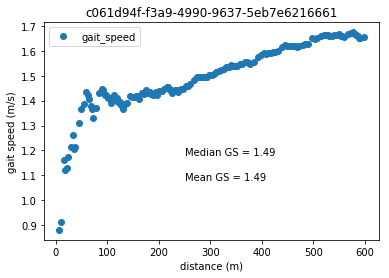

mean gait speed =  1.85
median gait speed =  1.82


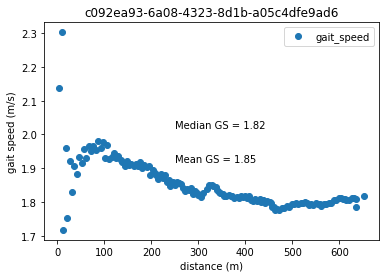

mean gait speed =  1.71
median gait speed =  1.66


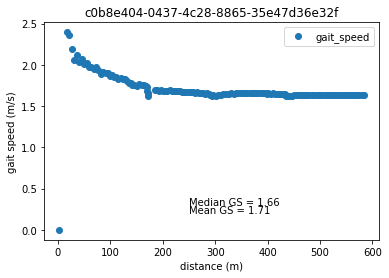

mean gait speed =  1.77
median gait speed =  1.77


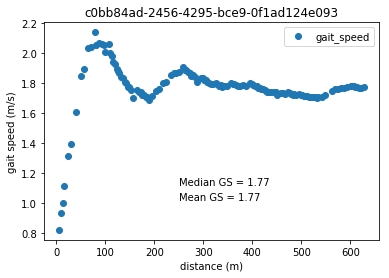

mean gait speed =  2.06
median gait speed =  2.08


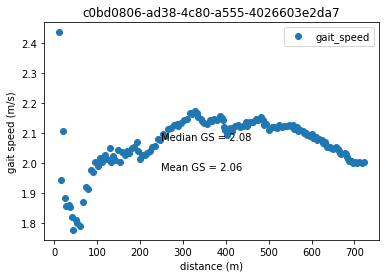

mean gait speed =  0.94
median gait speed =  0.96


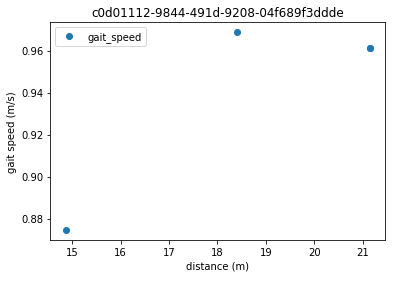

mean gait speed =  1.39
median gait speed =  1.38


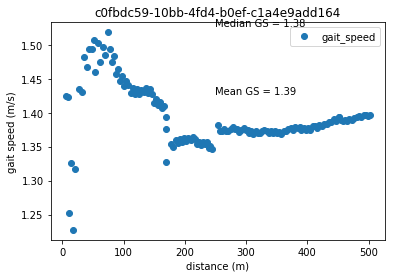

mean gait speed =  1.18
median gait speed =  1.19


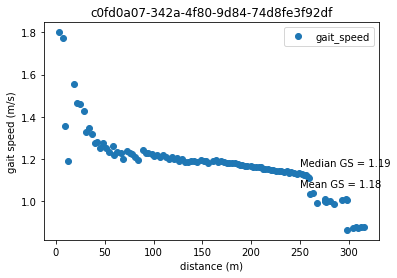

mean gait speed =  1.44
median gait speed =  1.44


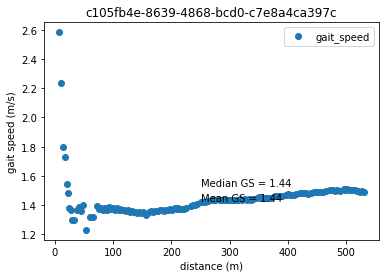

mean gait speed =  2.01
median gait speed =  2.0


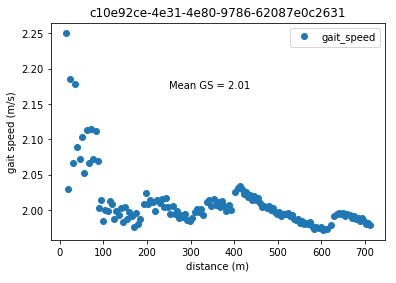

mean gait speed =  1.61
median gait speed =  1.58


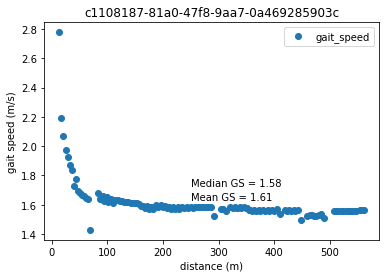

mean gait speed =  2.44
median gait speed =  2.66


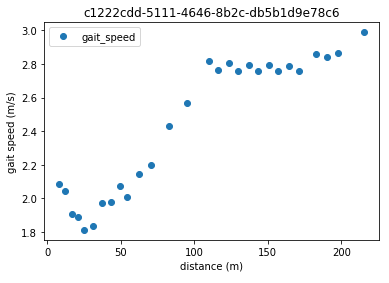

mean gait speed =  1.7
median gait speed =  1.88


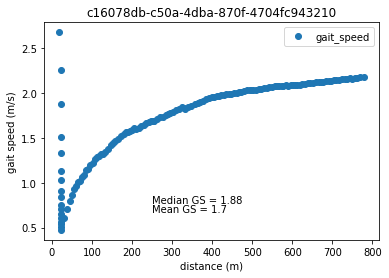

mean gait speed =  1.38
median gait speed =  1.35


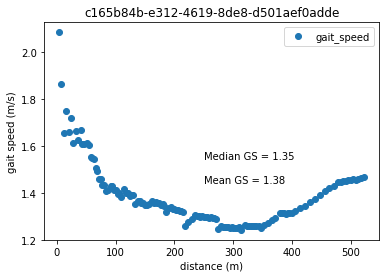

mean gait speed =  1.41
median gait speed =  1.46


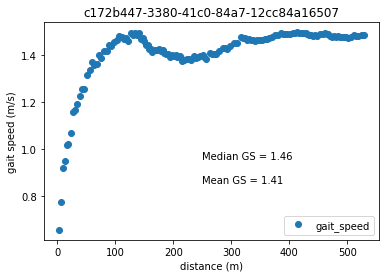

mean gait speed =  1.73
median gait speed =  1.8


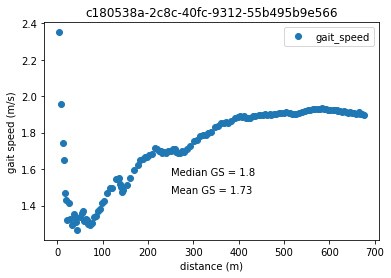

mean gait speed =  1.43
median gait speed =  1.41


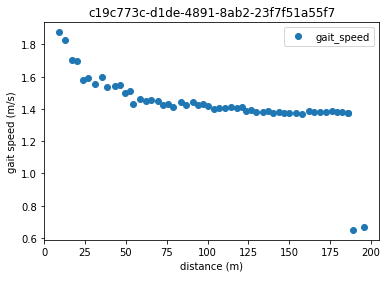

mean gait speed =  2.01
median gait speed =  1.98


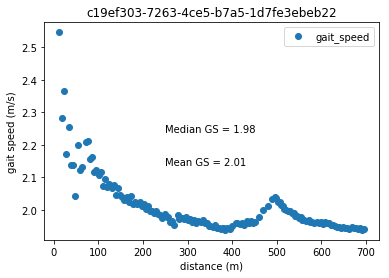

mean gait speed =  1.79
median gait speed =  1.8


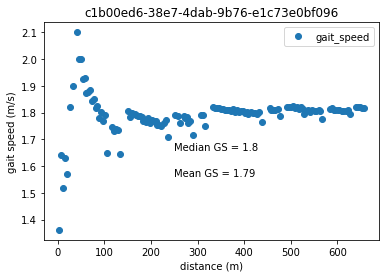

mean gait speed =  1.68
median gait speed =  1.66


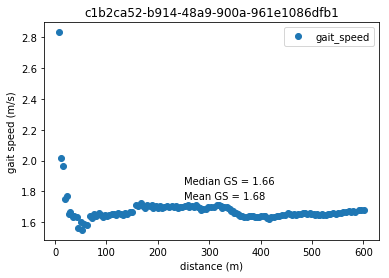

mean gait speed =  2.29
median gait speed =  2.38


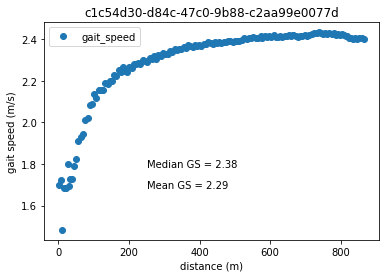

mean gait speed =  1.63
median gait speed =  1.62


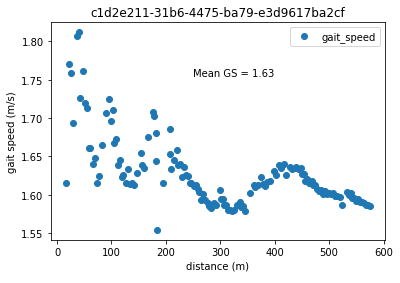

mean gait speed =  2.9
median gait speed =  2.9


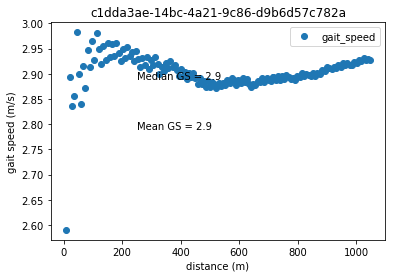

mean gait speed =  1.76
median gait speed =  1.72


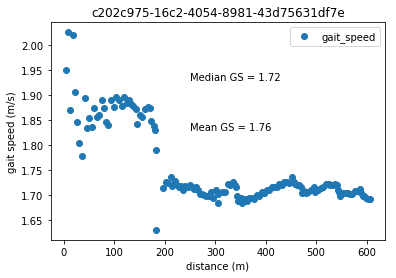

mean gait speed =  1.35
median gait speed =  1.35


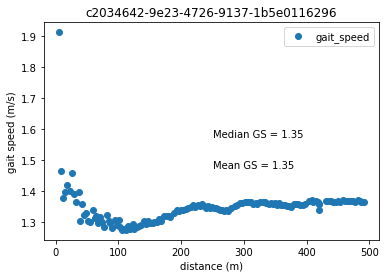

mean gait speed =  1.41
median gait speed =  1.4


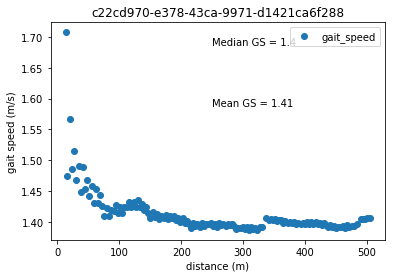

mean gait speed =  1.48
median gait speed =  1.41


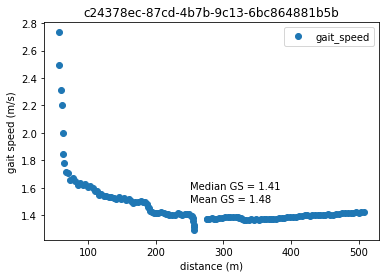

mean gait speed =  1.64
median gait speed =  1.67


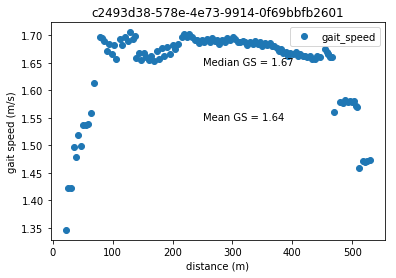

mean gait speed =  1.46
median gait speed =  1.44


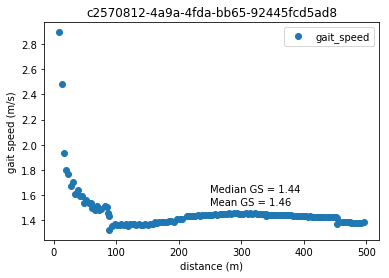

mean gait speed =  2.2
median gait speed =  2.21


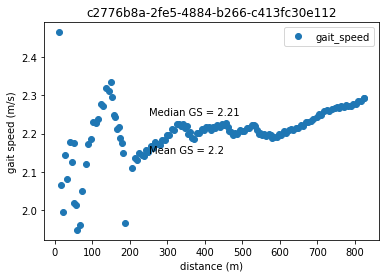

mean gait speed =  1.25
median gait speed =  1.34


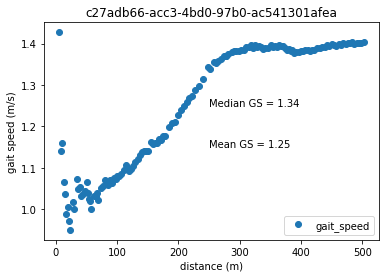

mean gait speed =  1.72
median gait speed =  1.68


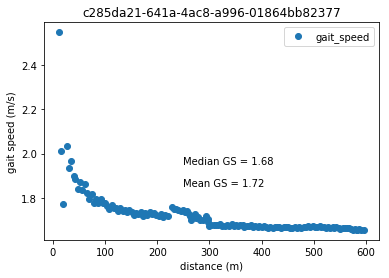

mean gait speed =  1.78
median gait speed =  1.74


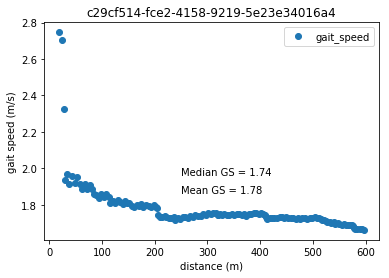

mean gait speed =  2.29
median gait speed =  2.25


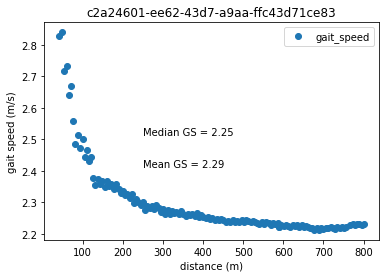

mean gait speed =  1.59
median gait speed =  1.58


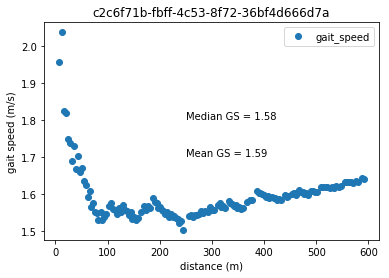

mean gait speed =  1.56
median gait speed =  1.54


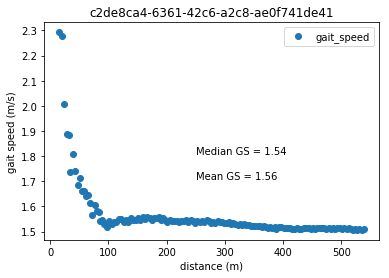

mean gait speed =  1.65
median gait speed =  1.65


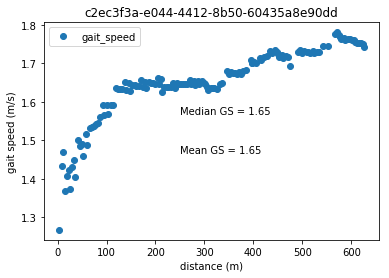

mean gait speed =  1.54
median gait speed =  1.53


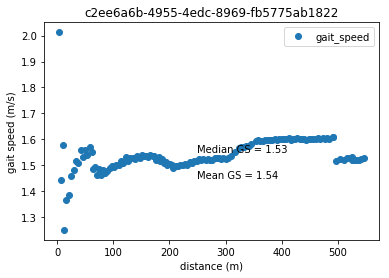

mean gait speed =  1.83
median gait speed =  1.81


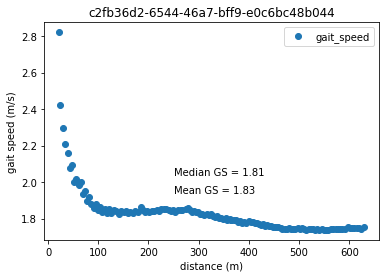

mean gait speed =  1.52
median gait speed =  1.51


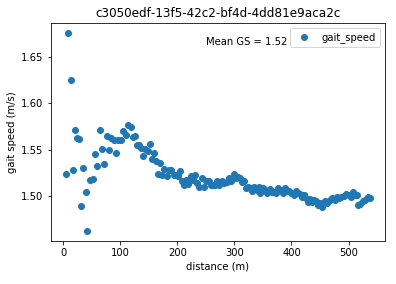

mean gait speed =  1.46
median gait speed =  1.49


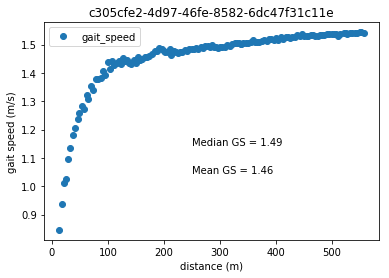

mean gait speed =  1.12
median gait speed =  1.07


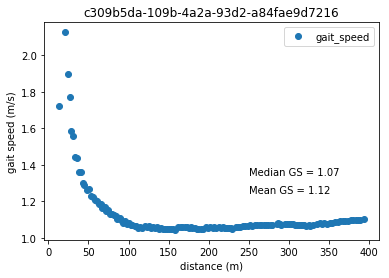

mean gait speed =  1.87
median gait speed =  1.87


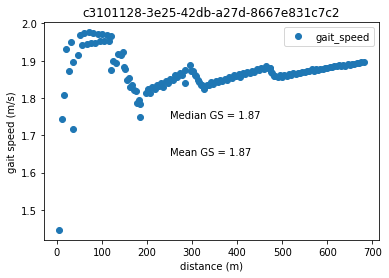

mean gait speed =  2.0
median gait speed =  2.1


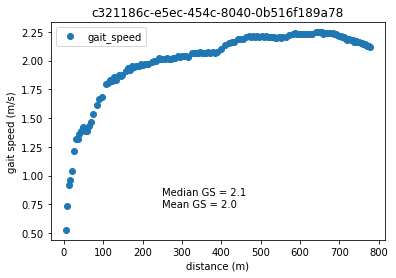

mean gait speed =  2.22
median gait speed =  2.2


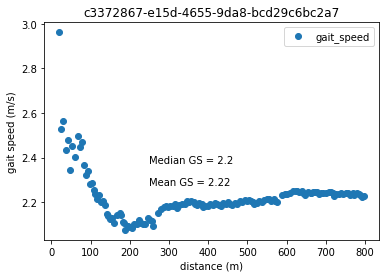

mean gait speed =  1.97
median gait speed =  2.09


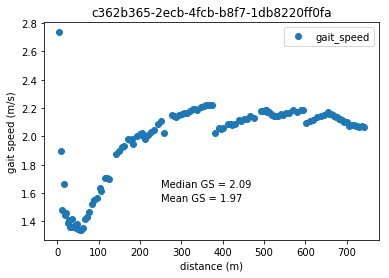

mean gait speed =  1.13
median gait speed =  1.15


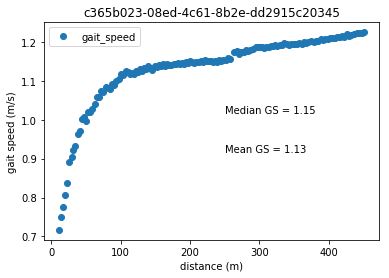

mean gait speed =  1.62
median gait speed =  1.59


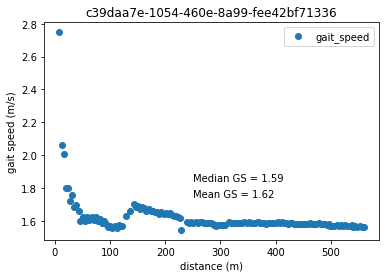

mean gait speed =  2.61
median gait speed =  2.81


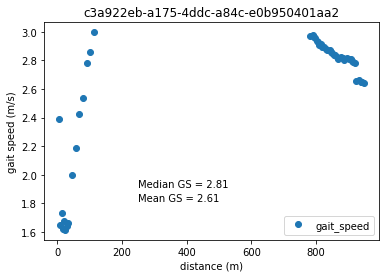

mean gait speed =  1.52
median gait speed =  1.53


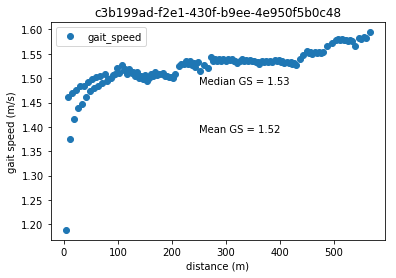

mean gait speed =  1.21
median gait speed =  1.29


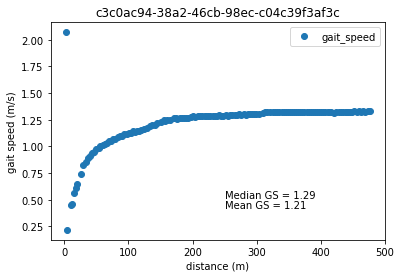

mean gait speed =  1.64
median gait speed =  1.61


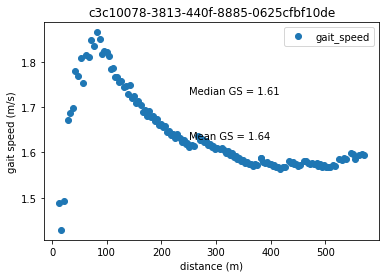

mean gait speed =  1.79
median gait speed =  1.77


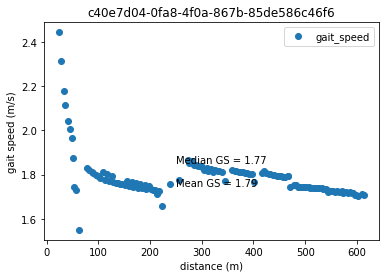

mean gait speed =  1.4
median gait speed =  1.42


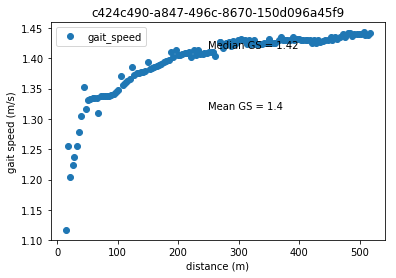

mean gait speed =  1.61
median gait speed =  1.59


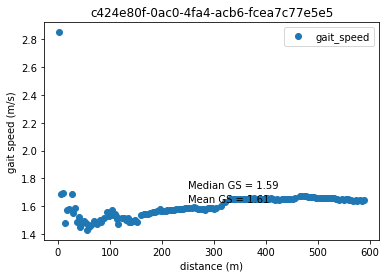

mean gait speed =  1.2
median gait speed =  1.22


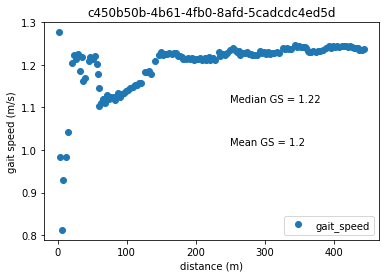

mean gait speed =  1.35
median gait speed =  1.31


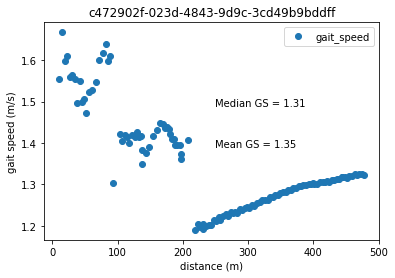

mean gait speed =  2.72
median gait speed =  2.83


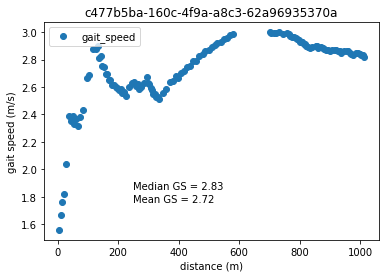

mean gait speed =  1.24
median gait speed =  1.26


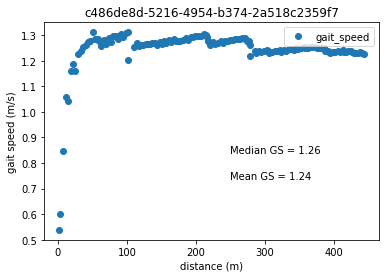

mean gait speed =  0.67
median gait speed =  0.69


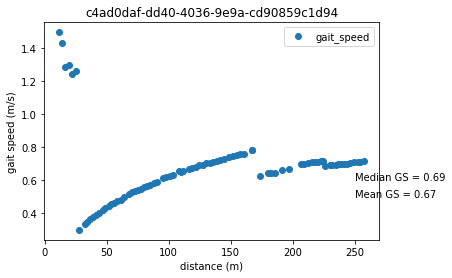

mean gait speed =  0.88
median gait speed =  0.86


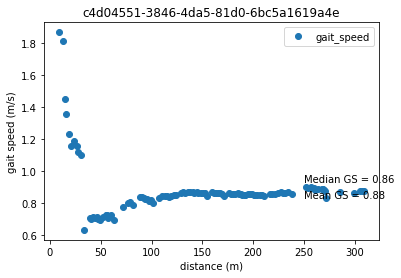

mean gait speed =  1.7
median gait speed =  1.7


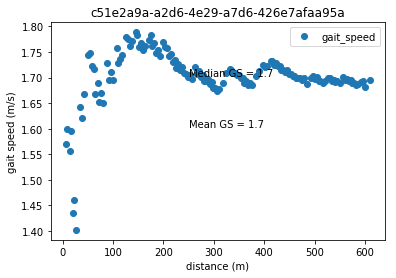

mean gait speed =  1.82
median gait speed =  1.85


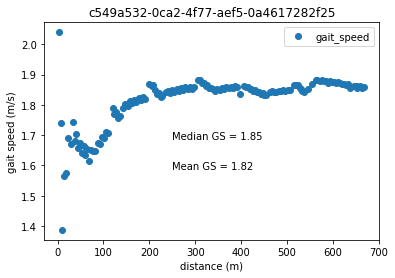

mean gait speed =  1.72
median gait speed =  1.67


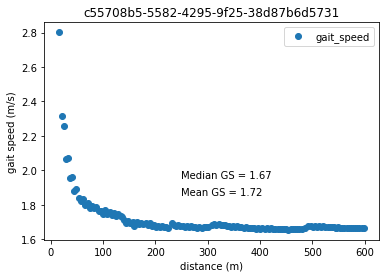

mean gait speed =  1.13
median gait speed =  1.1


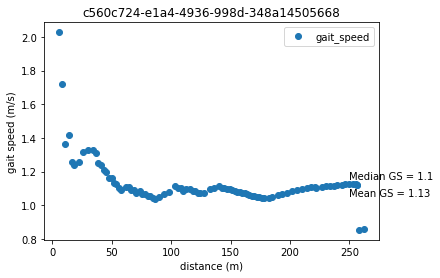

mean gait speed =  1.77
median gait speed =  1.78


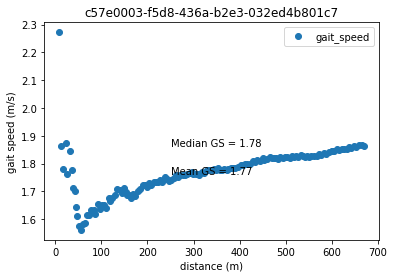

mean gait speed =  1.81
median gait speed =  1.77


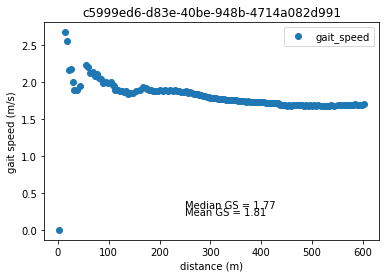

mean gait speed =  1.56
median gait speed =  1.59


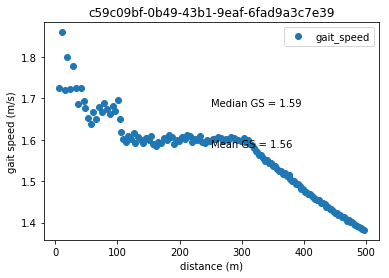

mean gait speed =  1.56
median gait speed =  1.56


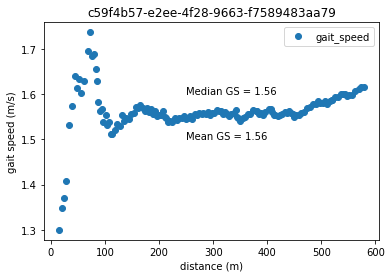

mean gait speed =  1.35
median gait speed =  1.32


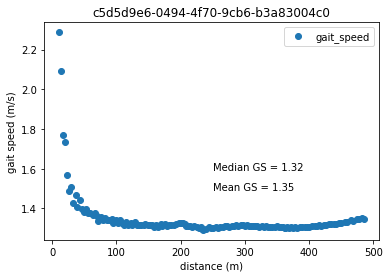

mean gait speed =  1.42
median gait speed =  1.44


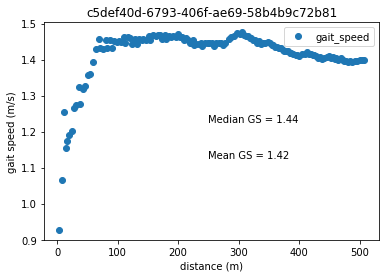

mean gait speed =  1.81
median gait speed =  1.84


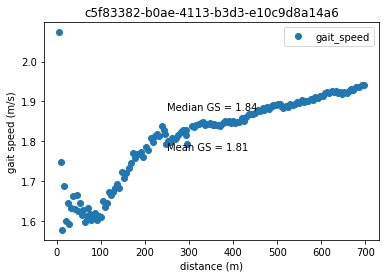

mean gait speed =  1.7
median gait speed =  1.69


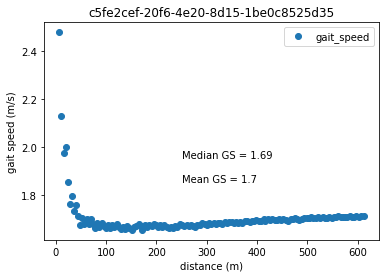

mean gait speed =  1.05
median gait speed =  1.1


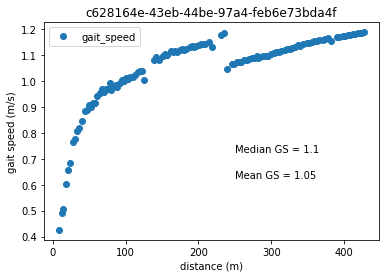

mean gait speed =  1.25
median gait speed =  1.31


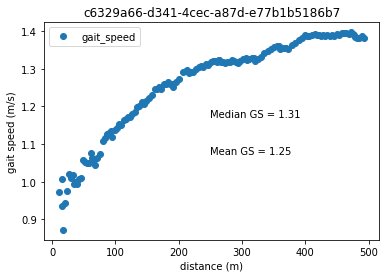

mean gait speed =  1.5
median gait speed =  1.49


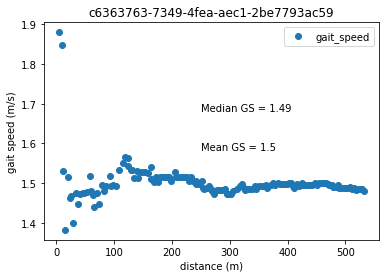

mean gait speed =  2.26
median gait speed =  2.31


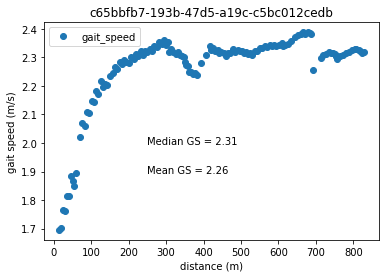

mean gait speed =  1.43
median gait speed =  1.46


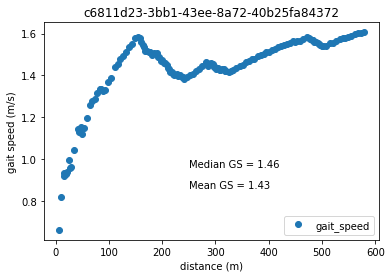

mean gait speed =  1.54
median gait speed =  1.53


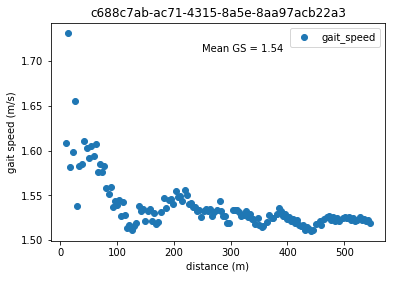

mean gait speed =  1.49
median gait speed =  1.53


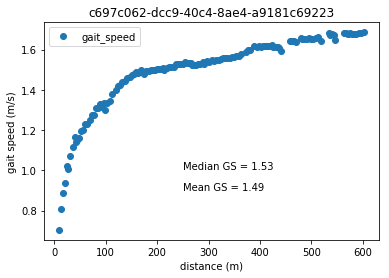

mean gait speed =  1.42
median gait speed =  1.39


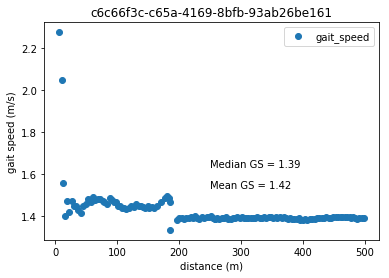

mean gait speed =  1.82
median gait speed =  1.77


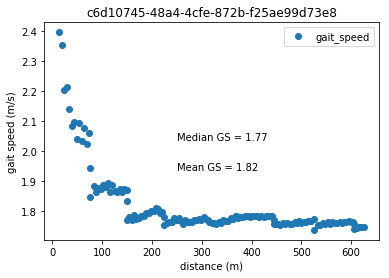

mean gait speed =  0.93
median gait speed =  0.9


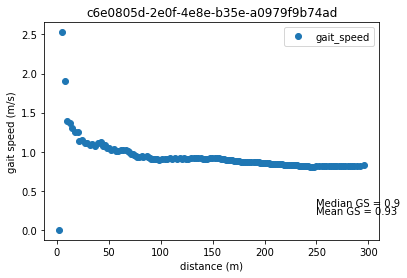

mean gait speed =  2.36
median gait speed =  2.4


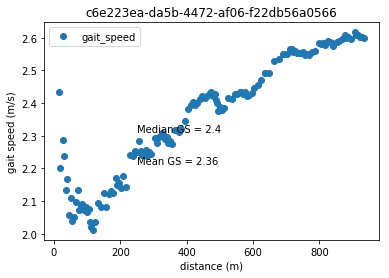

mean gait speed =  1.7
median gait speed =  1.65


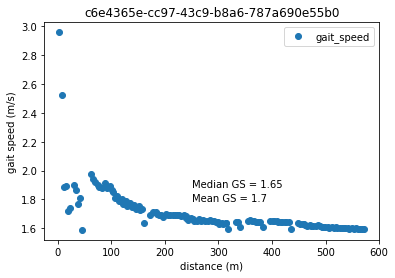

mean gait speed =  0.3
median gait speed =  0.32


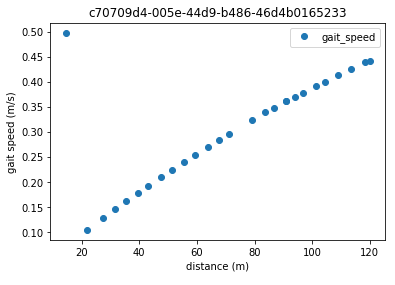

mean gait speed =  1.39
median gait speed =  1.36


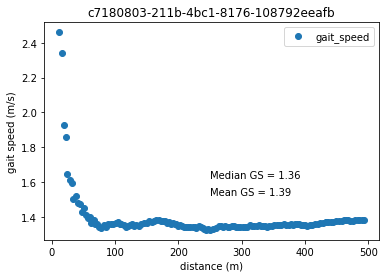

mean gait speed =  1.77
median gait speed =  1.81


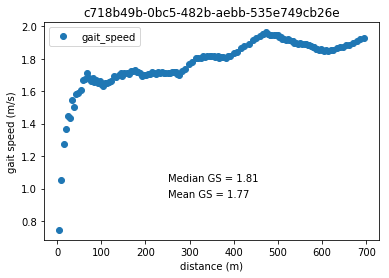

mean gait speed =  1.75
median gait speed =  1.73


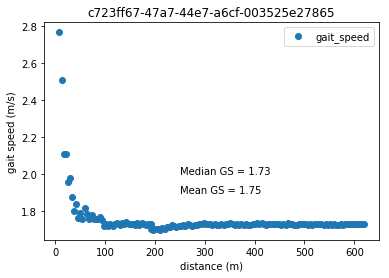

mean gait speed =  1.81
median gait speed =  1.81


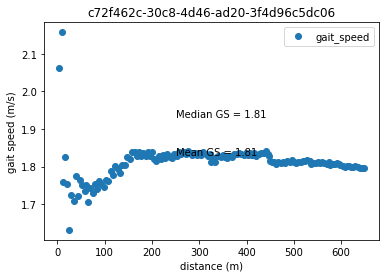

mean gait speed =  1.68
median gait speed =  1.67


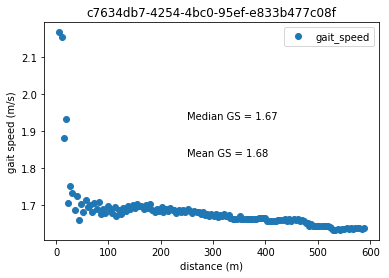

mean gait speed =  1.5
median gait speed =  1.49


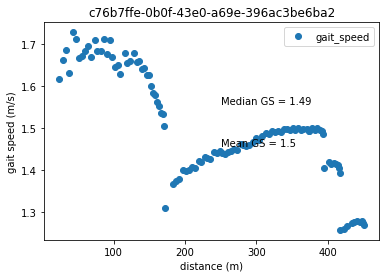

mean gait speed =  2.23
median gait speed =  2.22


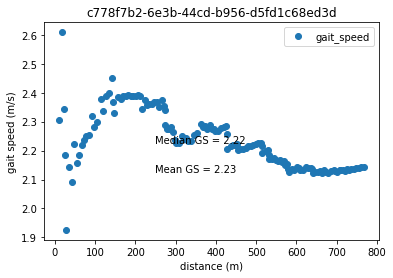

mean gait speed =  1.33
median gait speed =  1.32


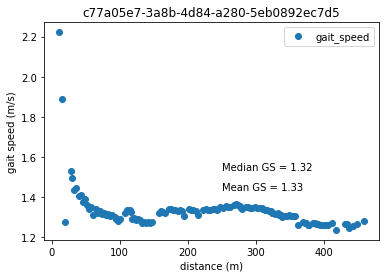

mean gait speed =  1.51
median gait speed =  1.52


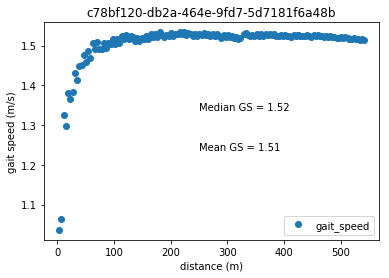

mean gait speed =  1.19
median gait speed =  1.19


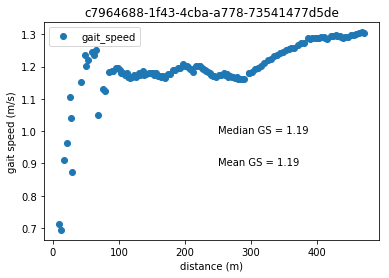

mean gait speed =  1.55
median gait speed =  1.61


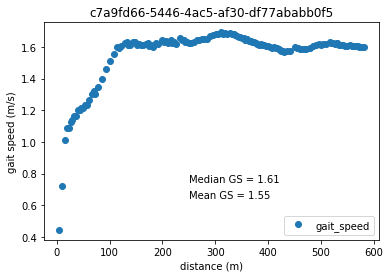

mean gait speed =  1.6
median gait speed =  1.59


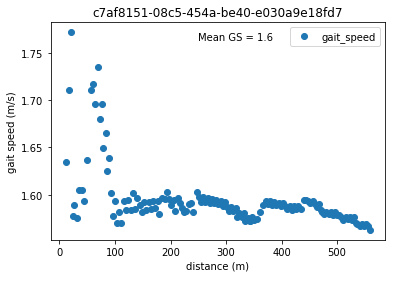

mean gait speed =  1.53
median gait speed =  1.54


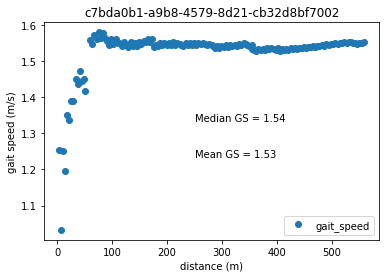

mean gait speed =  1.37
median gait speed =  1.38


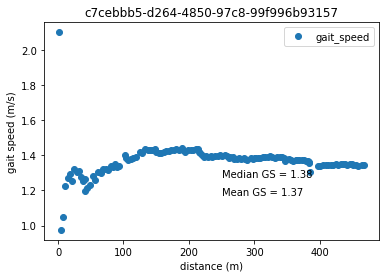

mean gait speed =  1.2
median gait speed =  1.19


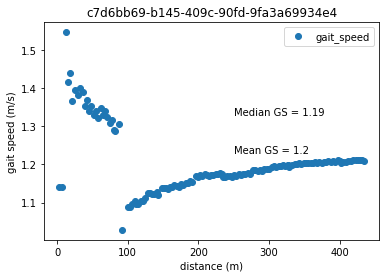

mean gait speed =  1.57
median gait speed =  1.56


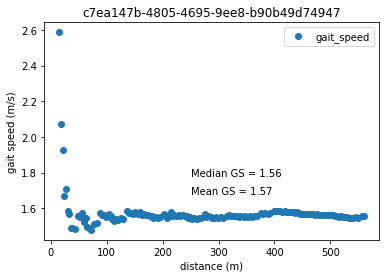

mean gait speed =  1.51
median gait speed =  1.51


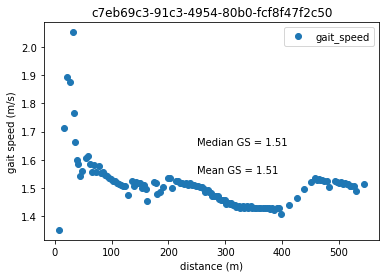

mean gait speed =  1.33
median gait speed =  1.29


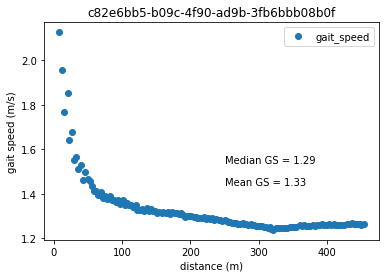

mean gait speed =  1.17
median gait speed =  1.15


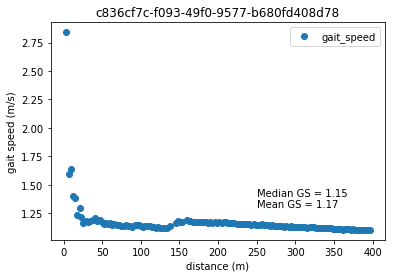

mean gait speed =  0.02
median gait speed =  0.02


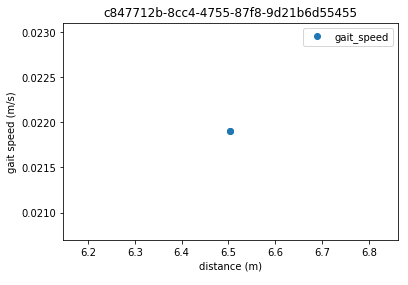

mean gait speed =  1.17
median gait speed =  1.14


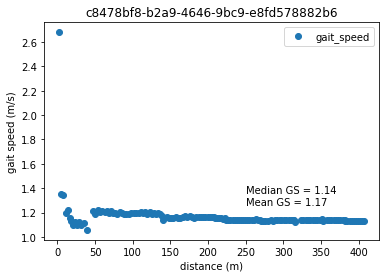

mean gait speed =  1.78
median gait speed =  1.76


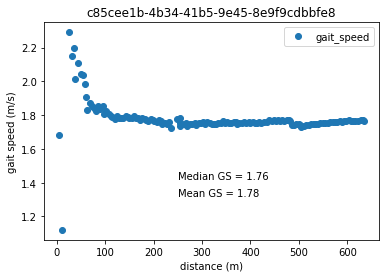

mean gait speed =  1.63
median gait speed =  1.58


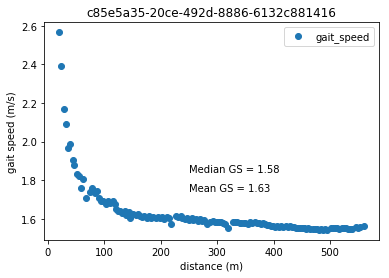

mean gait speed =  1.78
median gait speed =  1.79


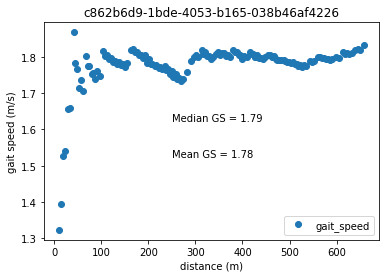

mean gait speed =  1.7
median gait speed =  1.71


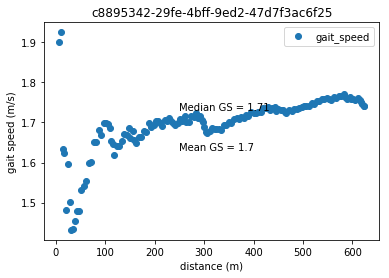

mean gait speed =  1.41
median gait speed =  1.37


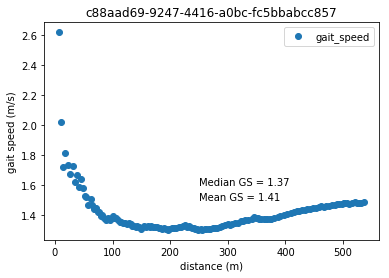

mean gait speed =  1.19
median gait speed =  1.2


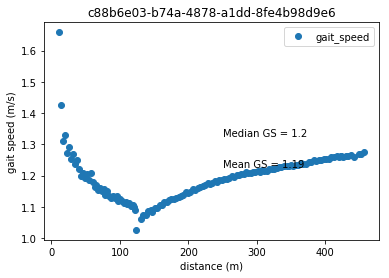

mean gait speed =  0.0
median gait speed =  0.0


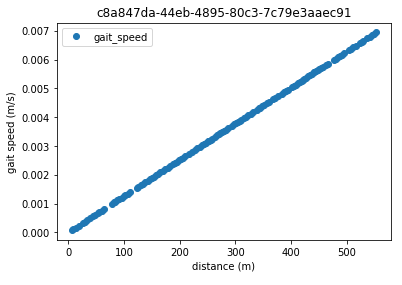

mean gait speed =  1.7
median gait speed =  1.66


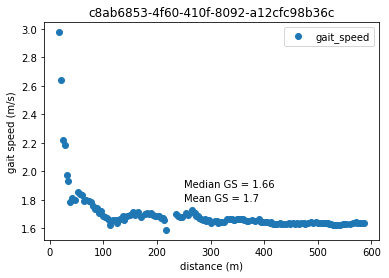

mean gait speed =  1.68
median gait speed =  1.68


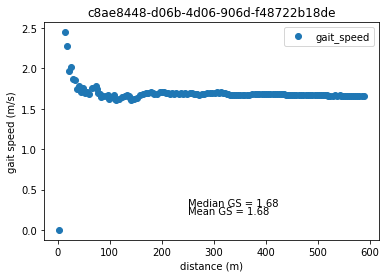

mean gait speed =  1.77
median gait speed =  1.79


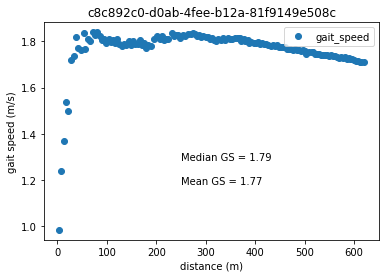

mean gait speed =  1.32
median gait speed =  1.37


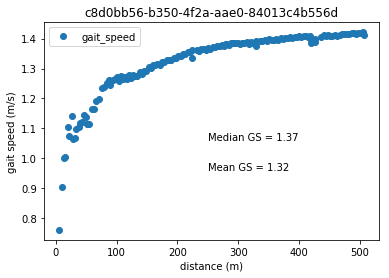

mean gait speed =  1.81
median gait speed =  1.75


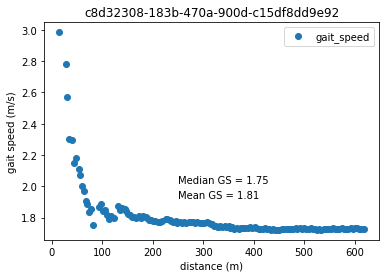

mean gait speed =  1.17
median gait speed =  1.19


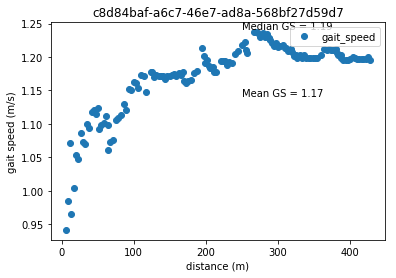

mean gait speed =  1.37
median gait speed =  1.36


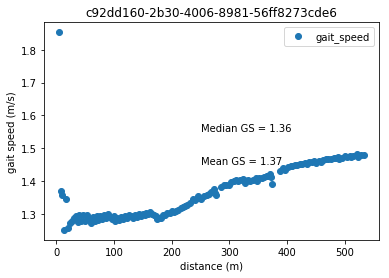

mean gait speed =  1.58
median gait speed =  1.59


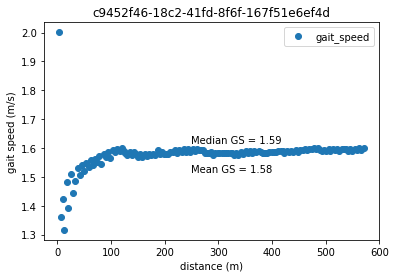

mean gait speed =  1.6
median gait speed =  1.61


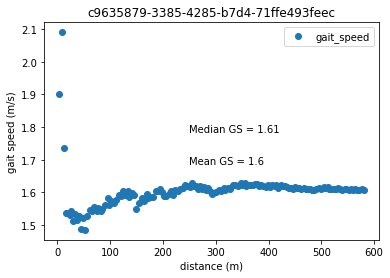

mean gait speed =  1.44
median gait speed =  1.45


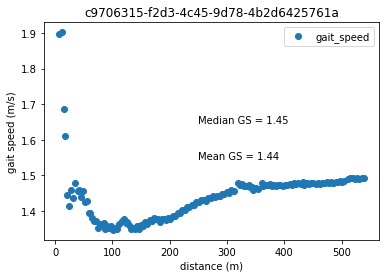

mean gait speed =  1.56
median gait speed =  1.57


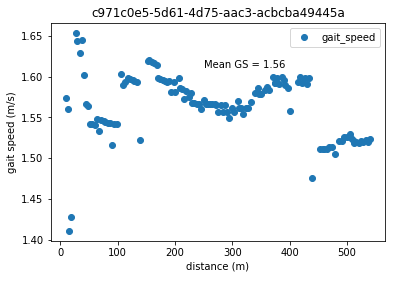

mean gait speed =  1.24
median gait speed =  1.23


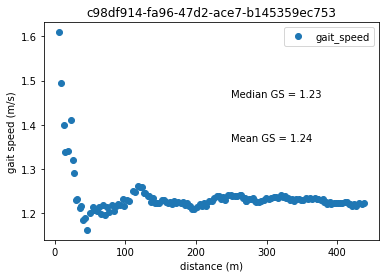

mean gait speed =  1.34
median gait speed =  1.34


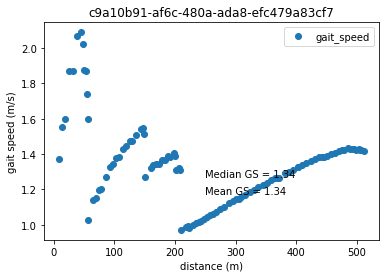

mean gait speed =  1.76
median gait speed =  1.8


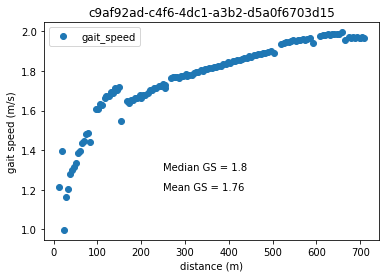

mean gait speed =  1.87
median gait speed =  2.14


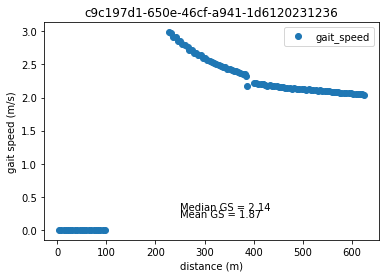

mean gait speed =  1.31
median gait speed =  1.33


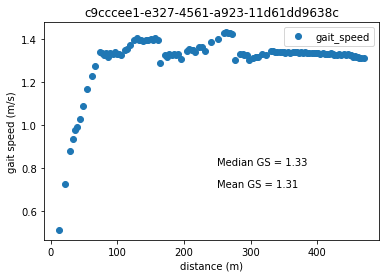

mean gait speed =  1.48
median gait speed =  1.47


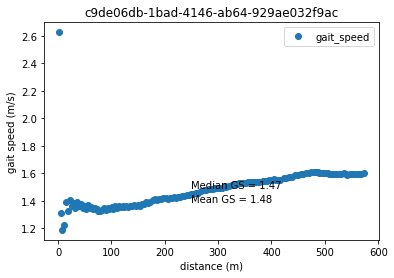

mean gait speed =  1.76
median gait speed =  1.79


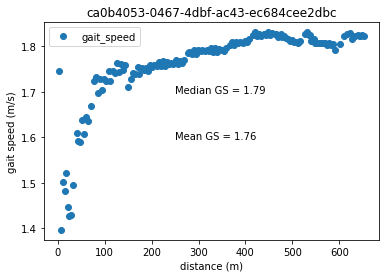

mean gait speed =  1.8
median gait speed =  1.79


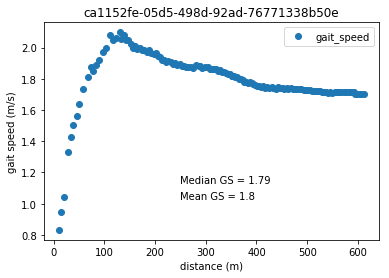

mean gait speed =  1.55
median gait speed =  1.59


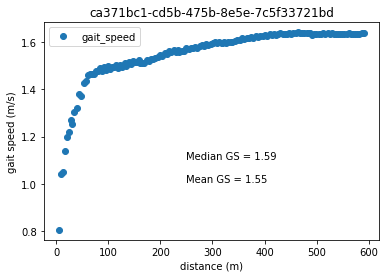

mean gait speed =  1.56
median gait speed =  1.55


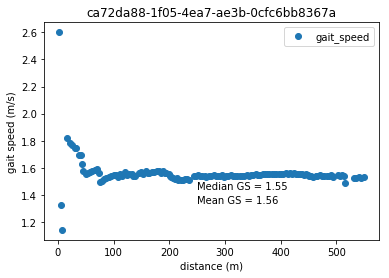

mean gait speed =  2.44
median gait speed =  2.42


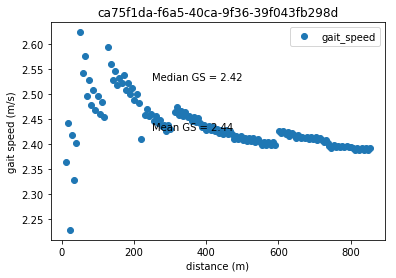

mean gait speed =  1.98
median gait speed =  1.96


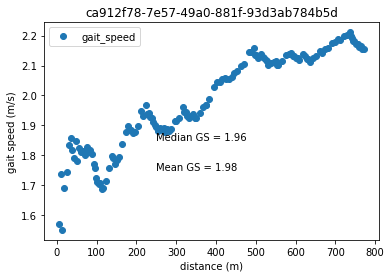

mean gait speed =  1.78
median gait speed =  1.77


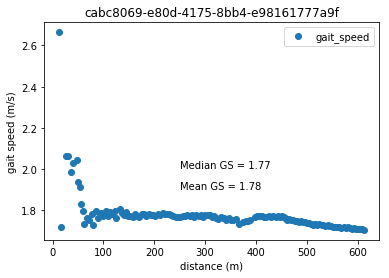

mean gait speed =  1.51
median gait speed =  1.52


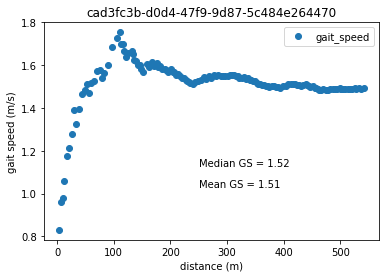

mean gait speed =  1.36
median gait speed =  1.36


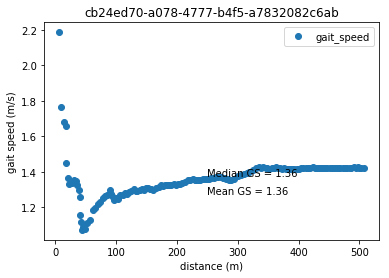

mean gait speed =  1.91
median gait speed =  1.93


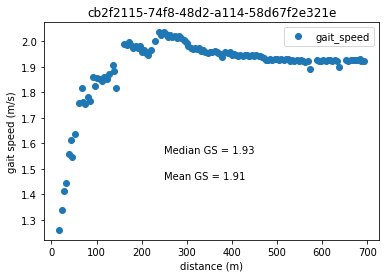

mean gait speed =  1.6
median gait speed =  1.57


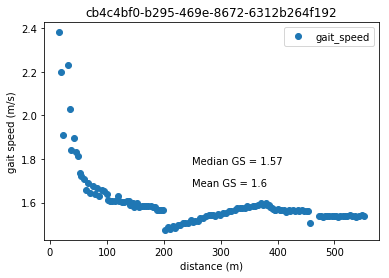

mean gait speed =  1.77
median gait speed =  1.76


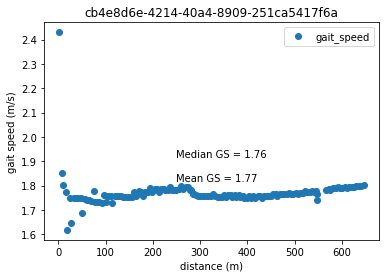

mean gait speed =  1.24
median gait speed =  1.24


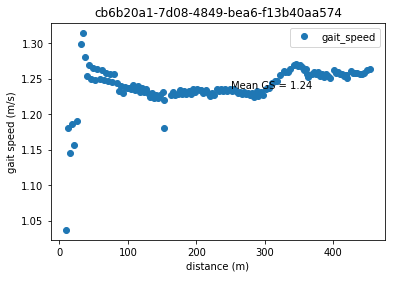

mean gait speed =  1.52
median gait speed =  1.54


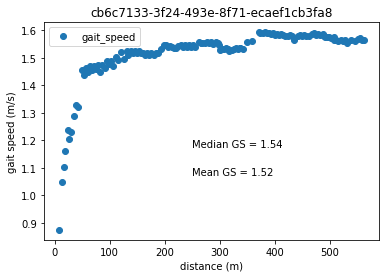

mean gait speed =  1.67
median gait speed =  1.66


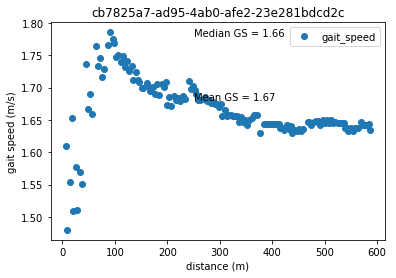

mean gait speed =  1.94
median gait speed =  1.94


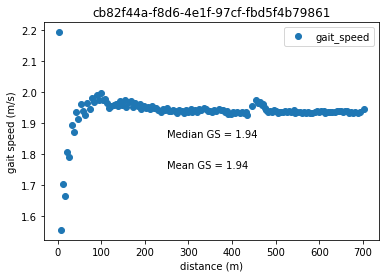

mean gait speed =  1.96
median gait speed =  1.95


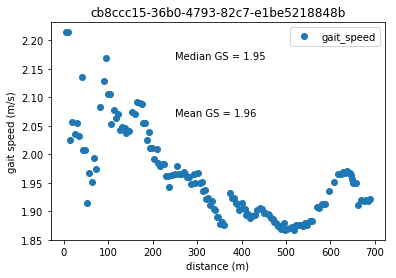

mean gait speed =  1.28
median gait speed =  1.23


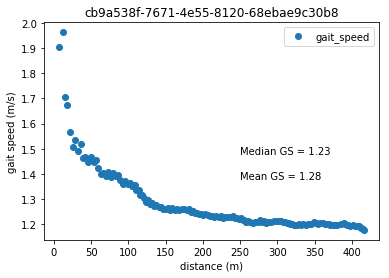

mean gait speed =  2.7
median gait speed =  2.75


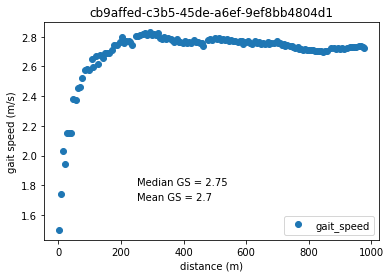

mean gait speed =  1.16
median gait speed =  1.24


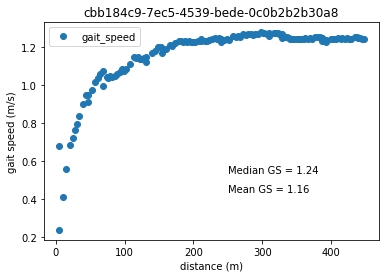

mean gait speed =  1.57
median gait speed =  1.54


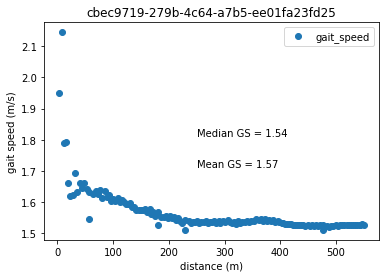

mean gait speed =  1.22
median gait speed =  1.24


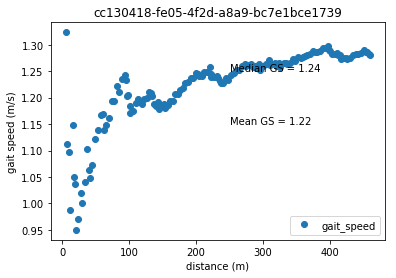

mean gait speed =  1.57
median gait speed =  1.61


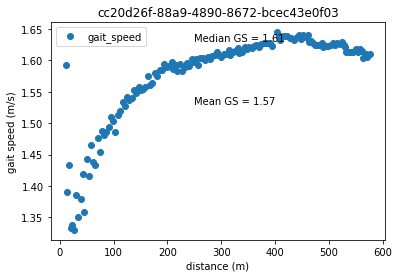

mean gait speed =  2.85
median gait speed =  2.84


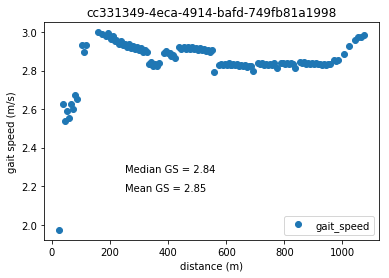

mean gait speed =  1.56
median gait speed =  1.62


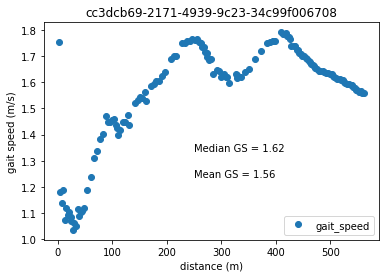

mean gait speed =  1.87
median gait speed =  1.87


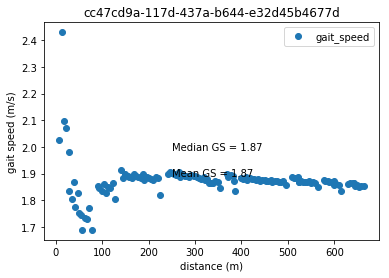

mean gait speed =  1.42
median gait speed =  1.44


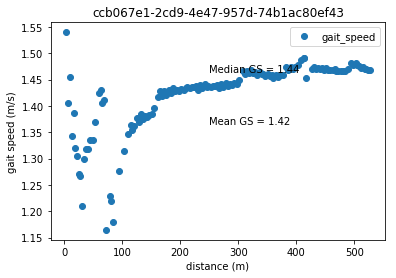

mean gait speed =  1.46
median gait speed =  1.51


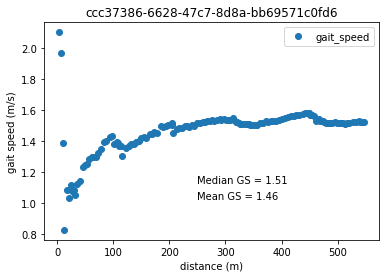

mean gait speed =  1.53
median gait speed =  1.52


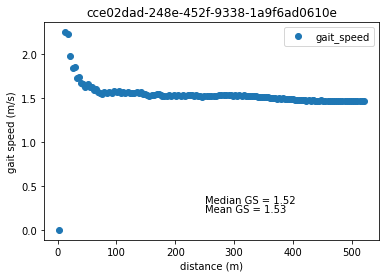

mean gait speed =  2.01
median gait speed =  2.1


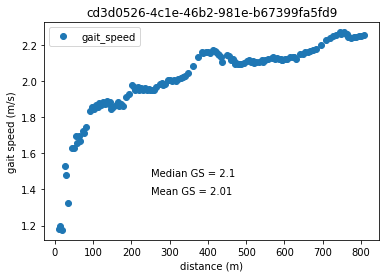

mean gait speed =  1.41
median gait speed =  1.41


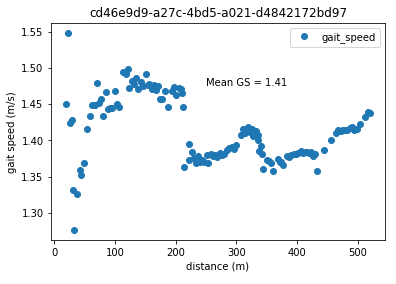

mean gait speed =  1.04
median gait speed =  1.07


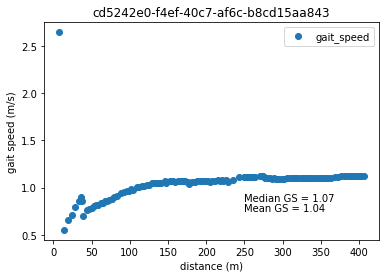

mean gait speed =  1.28
median gait speed =  1.28


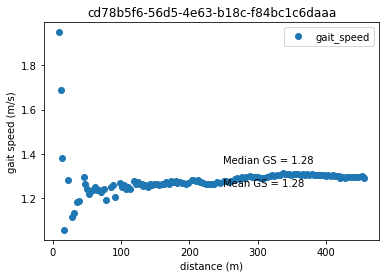

mean gait speed =  1.76
median gait speed =  1.77


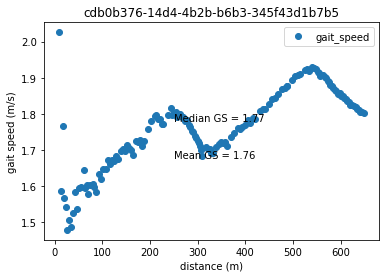

mean gait speed =  1.68
median gait speed =  1.74


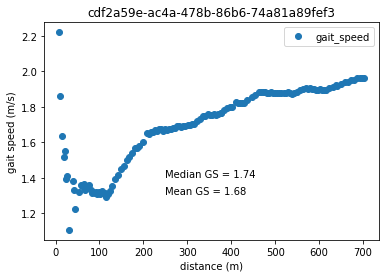

mean gait speed =  1.27
median gait speed =  1.2


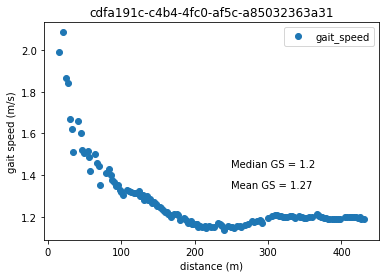

mean gait speed =  1.55
median gait speed =  1.56


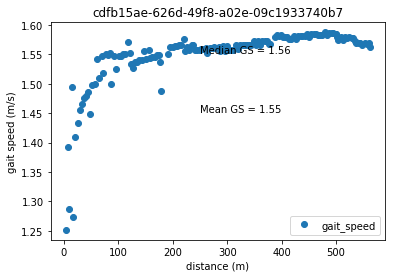

mean gait speed =  2.9
median gait speed =  2.96


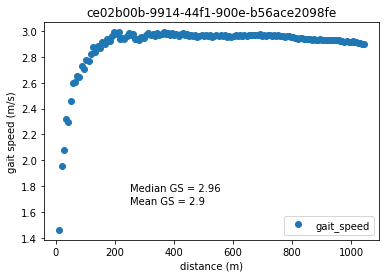

mean gait speed =  1.53
median gait speed =  1.52


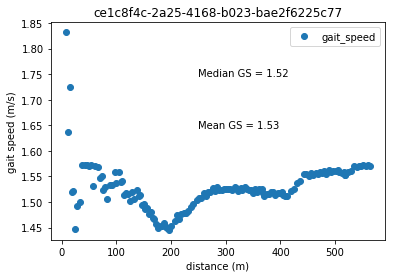

mean gait speed =  1.86
median gait speed =  1.82


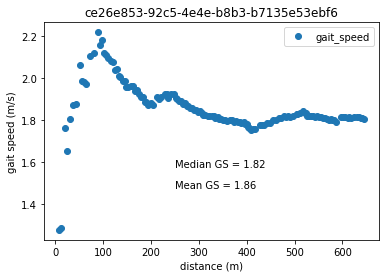

mean gait speed =  0.92
median gait speed =  0.99


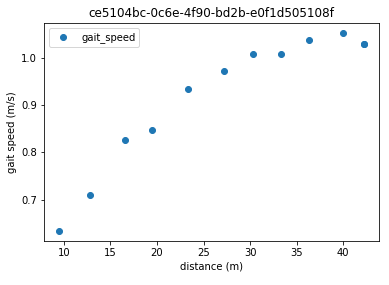

mean gait speed =  0.96
median gait speed =  0.95


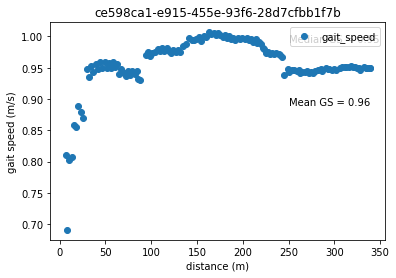

mean gait speed =  1.34
median gait speed =  1.33


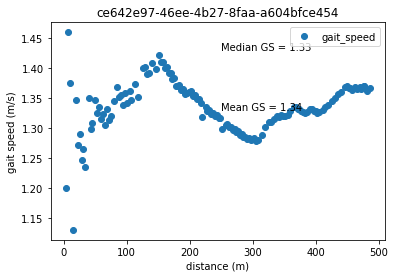

mean gait speed =  1.97
median gait speed =  1.98


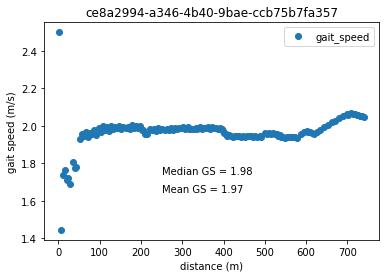

mean gait speed =  2.05
median gait speed =  2.0


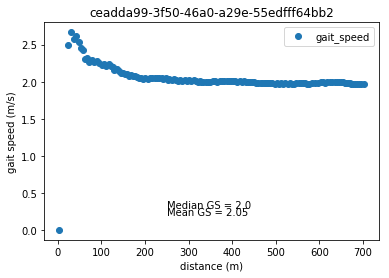

mean gait speed =  1.6
median gait speed =  1.58


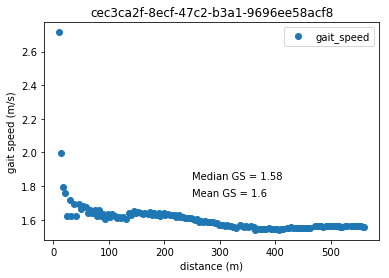

mean gait speed =  1.62
median gait speed =  1.58


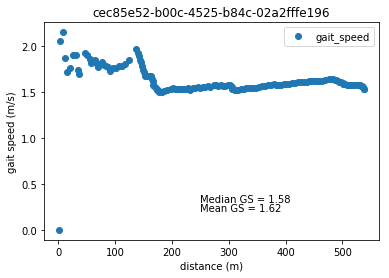

mean gait speed =  1.35
median gait speed =  1.39


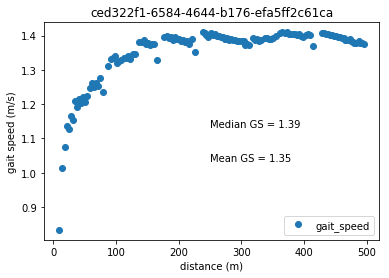

mean gait speed =  2.05
median gait speed =  2.07


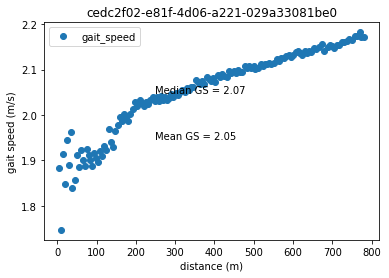

mean gait speed =  0.82
median gait speed =  0.68


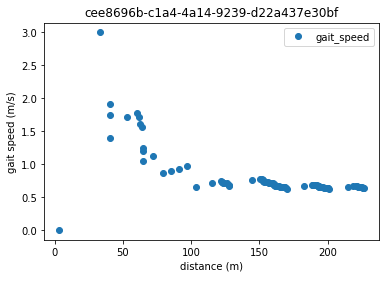

mean gait speed =  1.66
median gait speed =  1.66


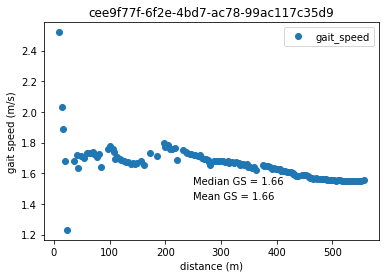

mean gait speed =  2.55
median gait speed =  2.6


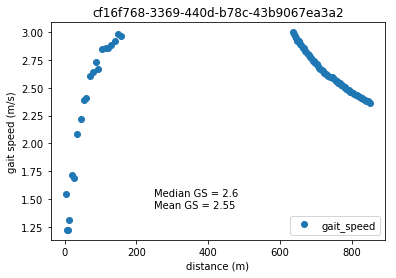

mean gait speed =  2.21
median gait speed =  2.18


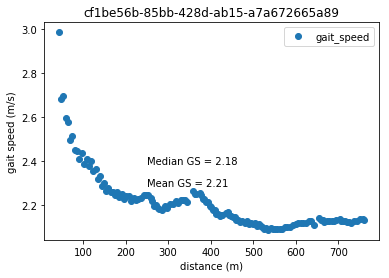

mean gait speed =  1.94
median gait speed =  1.92


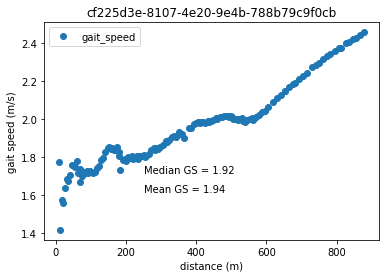

mean gait speed =  1.36
median gait speed =  1.35


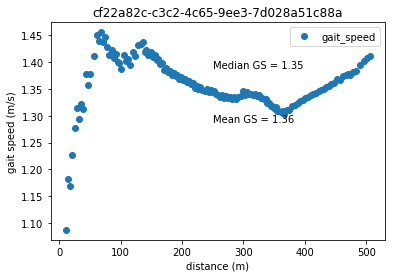

mean gait speed =  1.65
median gait speed =  1.66


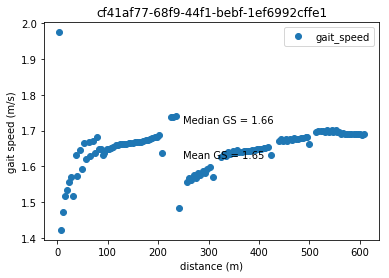

mean gait speed =  1.29
median gait speed =  1.29


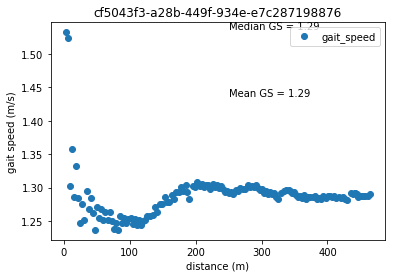

mean gait speed =  1.45
median gait speed =  1.45


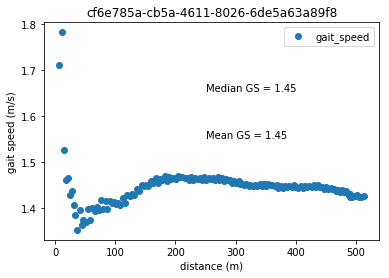

mean gait speed =  2.18
median gait speed =  2.21


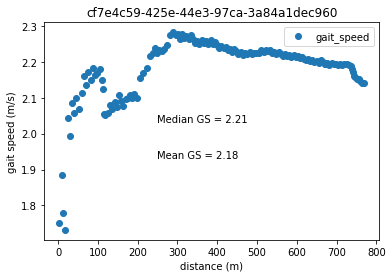

mean gait speed =  1.42
median gait speed =  1.45


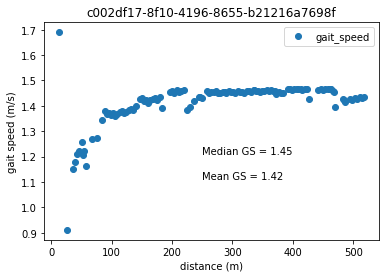

mean gait speed =  1.78
median gait speed =  1.72


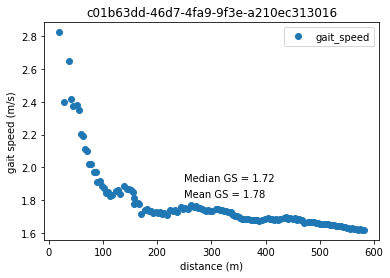

mean gait speed =  1.68
median gait speed =  1.68


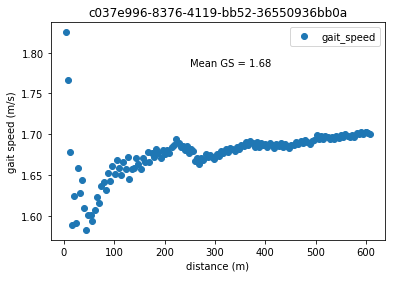

mean gait speed =  1.73
median gait speed =  1.85


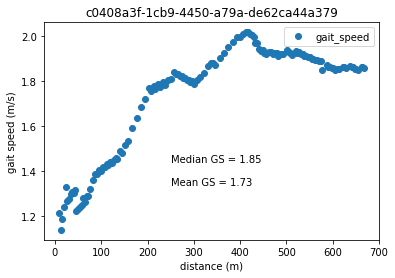

mean gait speed =  2.49
median gait speed =  2.53


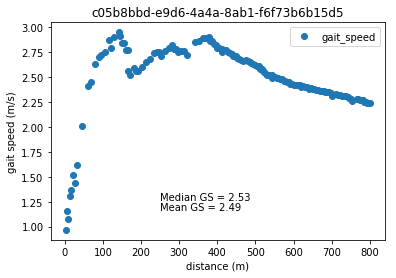

mean gait speed =  2.3
median gait speed =  2.22


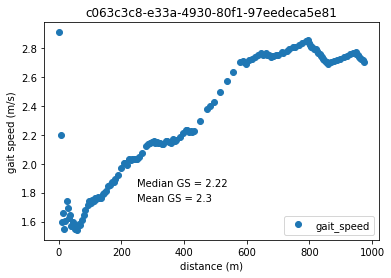

mean gait speed =  1.51
median gait speed =  1.66


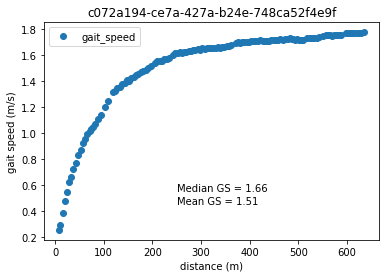

mean gait speed =  1.35
median gait speed =  1.34


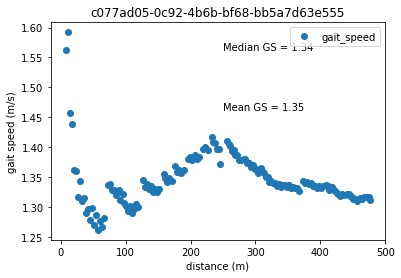

mean gait speed =  0.0
median gait speed =  0.0


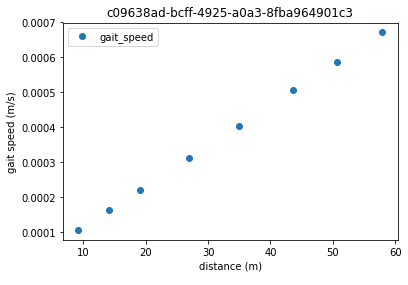

mean gait speed =  1.68
median gait speed =  1.67


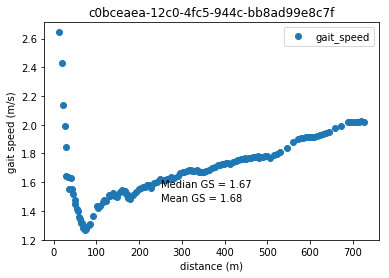

mean gait speed =  1.63
median gait speed =  1.57


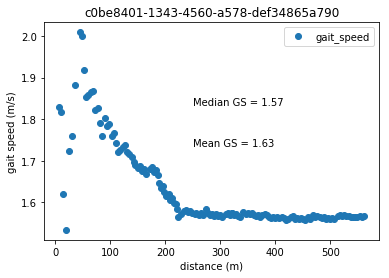

mean gait speed =  1.67
median gait speed =  1.69


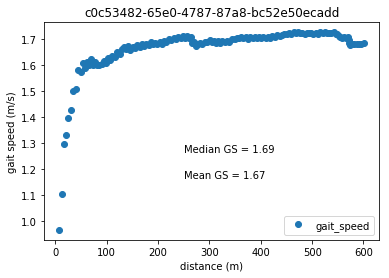

mean gait speed =  1.65
median gait speed =  1.73


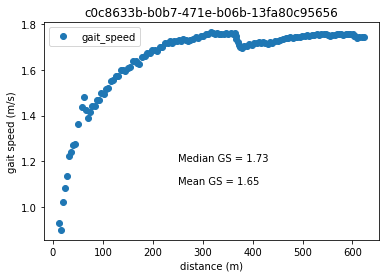

mean gait speed =  1.2
median gait speed =  1.13


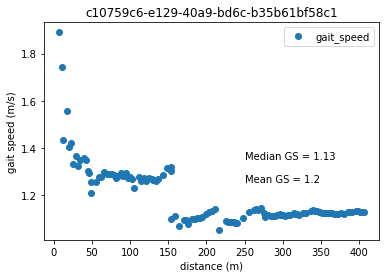

mean gait speed =  2.07
median gait speed =  2.1


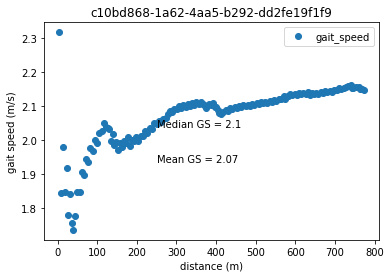

mean gait speed =  1.84
median gait speed =  1.78


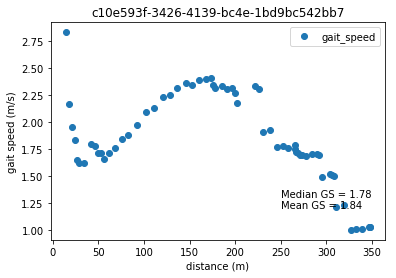

mean gait speed =  1.59
median gait speed =  1.5


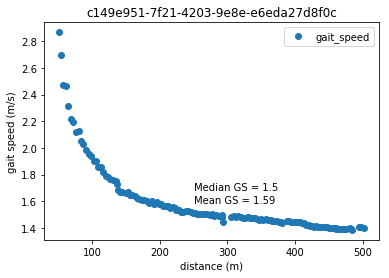

mean gait speed =  1.48
median gait speed =  1.55


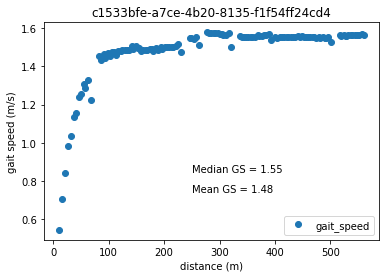

mean gait speed =  2.03
median gait speed =  2.0


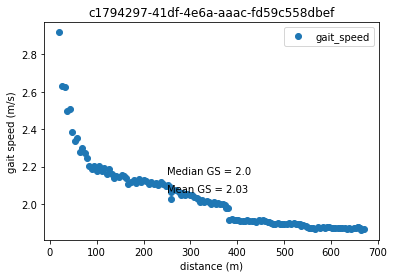

mean gait speed =  2.58
median gait speed =  2.7


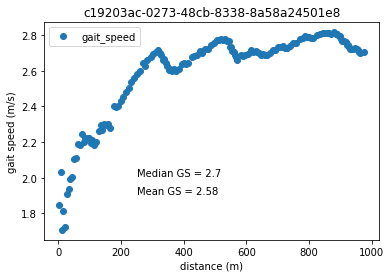

mean gait speed =  1.69
median gait speed =  1.57


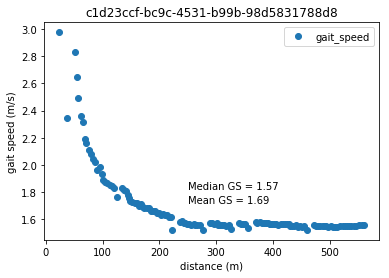

mean gait speed =  1.51
median gait speed =  1.48


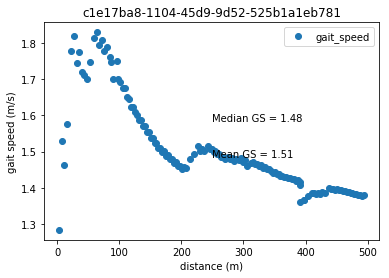

mean gait speed =  2.72
median gait speed =  2.73


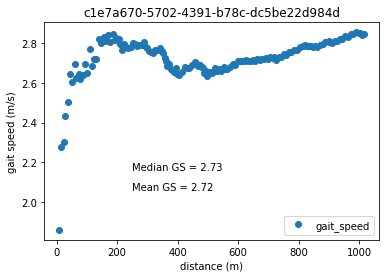

mean gait speed =  1.64
median gait speed =  1.59


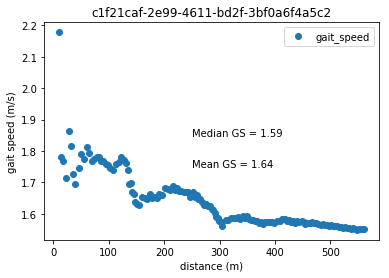

mean gait speed =  1.74
median gait speed =  1.67


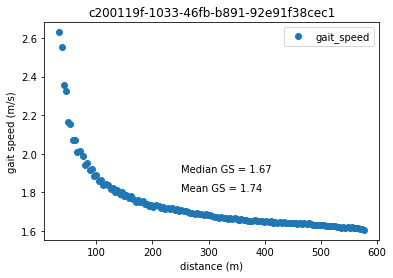

mean gait speed =  1.23
median gait speed =  1.23


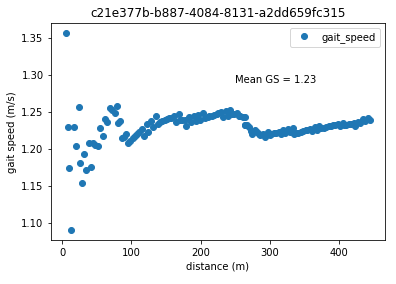

mean gait speed =  1.88
median gait speed =  1.88


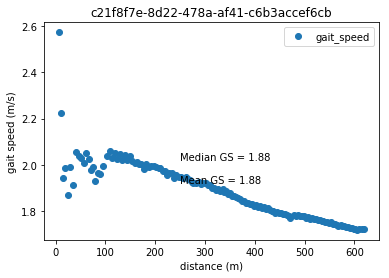

mean gait speed =  1.44
median gait speed =  1.51


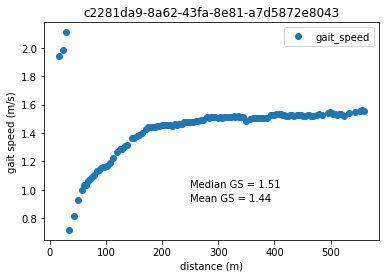

mean gait speed =  1.53
median gait speed =  1.48


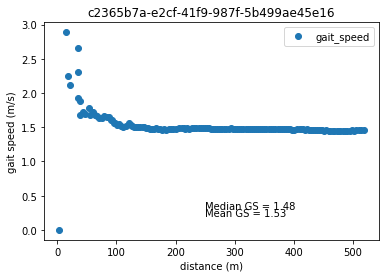

mean gait speed =  1.63
median gait speed =  1.62


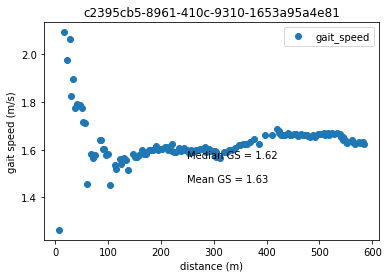

mean gait speed =  1.72
median gait speed =  1.75


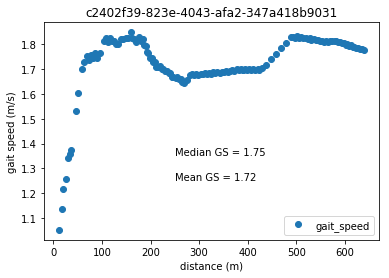

mean gait speed =  1.27
median gait speed =  1.26


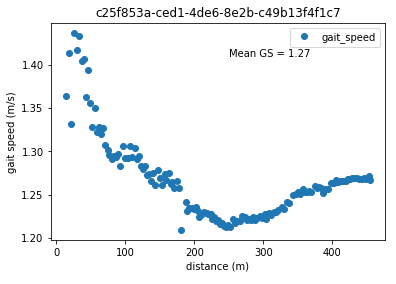

mean gait speed =  1.63
median gait speed =  1.65


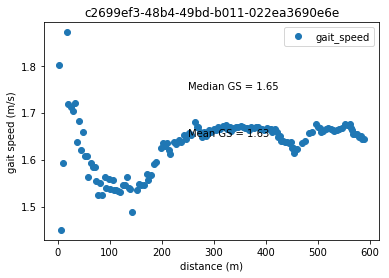

mean gait speed =  1.37
median gait speed =  1.4


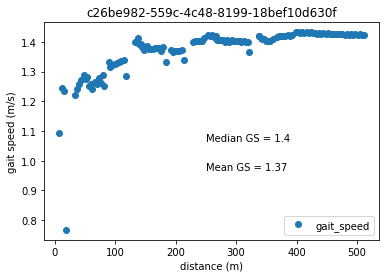

mean gait speed =  1.72
median gait speed =  1.73


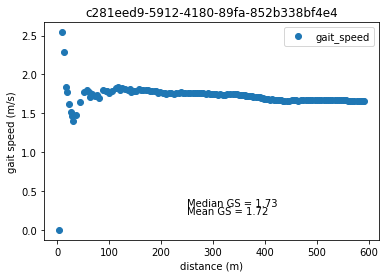

mean gait speed =  1.39
median gait speed =  1.4


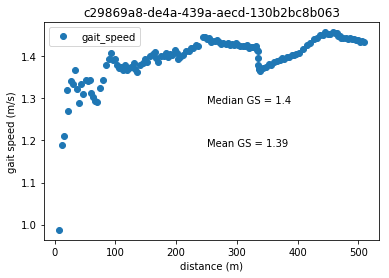

mean gait speed =  1.57
median gait speed =  1.53


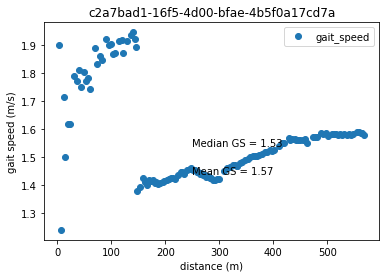

mean gait speed =  1.18
median gait speed =  1.16


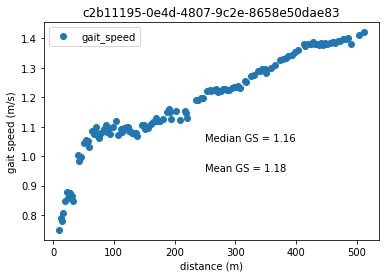

mean gait speed =  1.37
median gait speed =  1.3


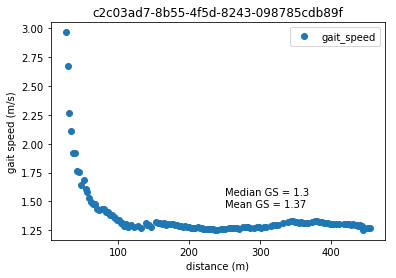

mean gait speed =  1.59
median gait speed =  1.66


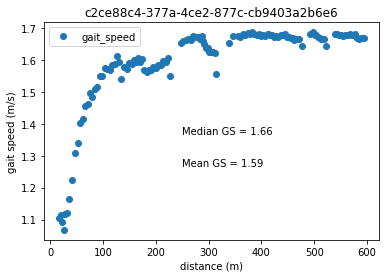

mean gait speed =  1.18
median gait speed =  1.16


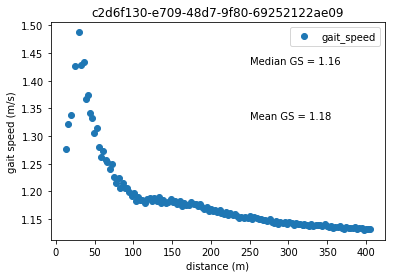

mean gait speed =  1.8
median gait speed =  1.79


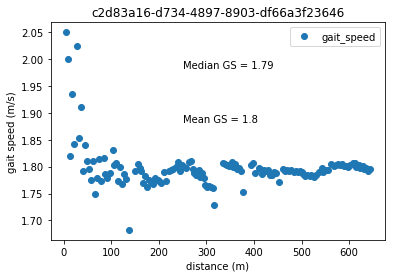

mean gait speed =  1.24
median gait speed =  1.23


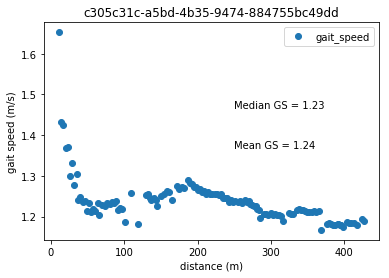

mean gait speed =  1.79
median gait speed =  1.76


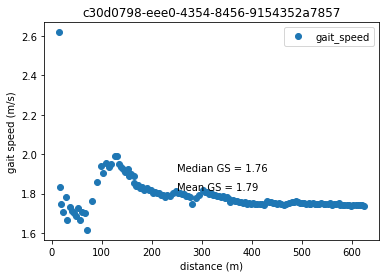

mean gait speed =  1.73
median gait speed =  1.76


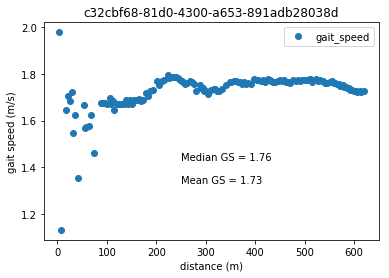

mean gait speed =  1.8
median gait speed =  1.79


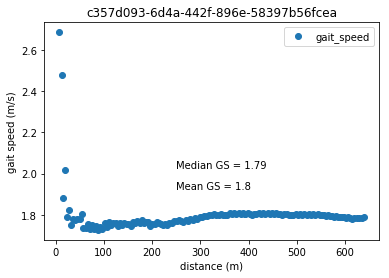

mean gait speed =  1.01
median gait speed =  1.12


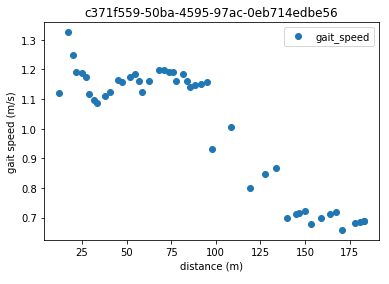

mean gait speed =  2.27
median gait speed =  2.4


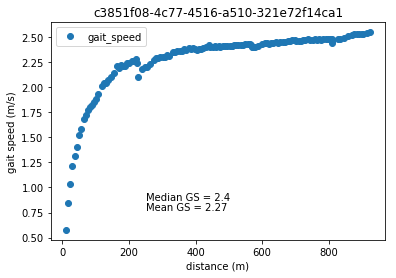

mean gait speed =  1.38
median gait speed =  1.42


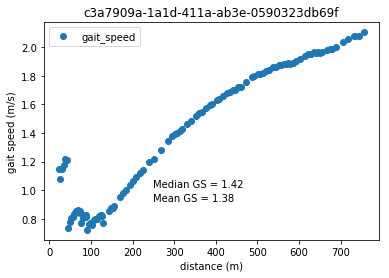

mean gait speed =  2.1
median gait speed =  2.09


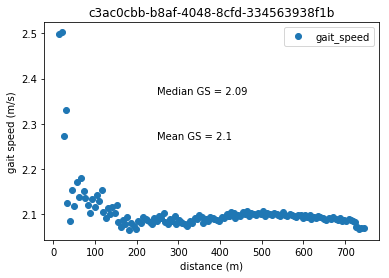

mean gait speed =  1.63
median gait speed =  1.61


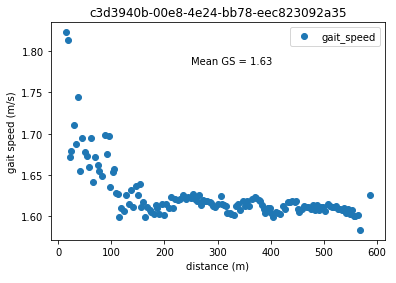

mean gait speed =  0.99
median gait speed =  1.03


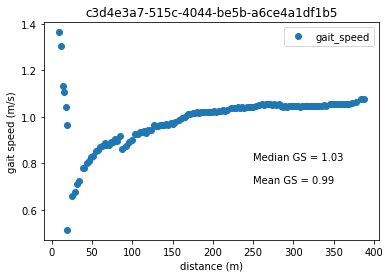

mean gait speed =  1.25
median gait speed =  1.27


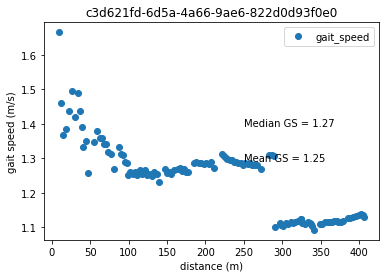

mean gait speed =  1.66
median gait speed =  1.69


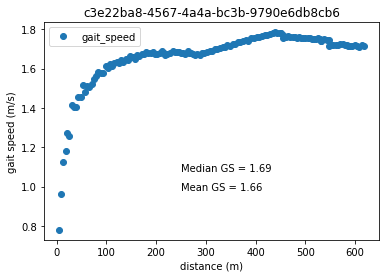

mean gait speed =  1.86
median gait speed =  1.83


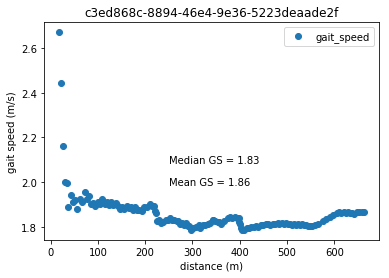

mean gait speed =  1.72
median gait speed =  1.68


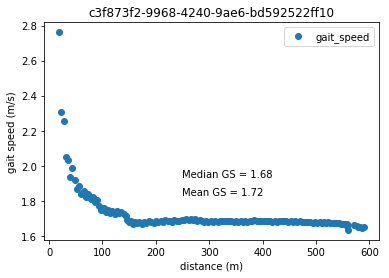

mean gait speed =  2.18
median gait speed =  2.18


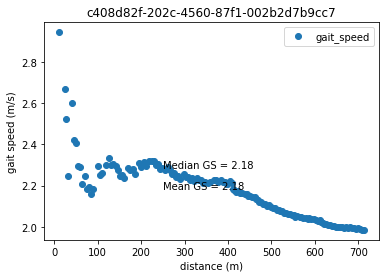

mean gait speed =  1.45
median gait speed =  1.45


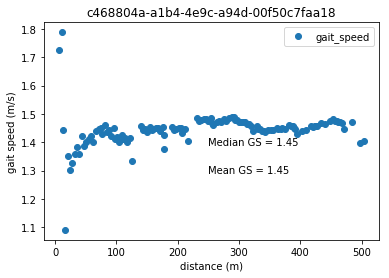

mean gait speed =  1.24
median gait speed =  1.25


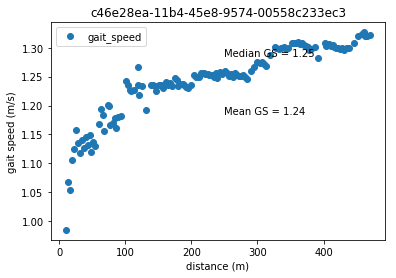

mean gait speed =  1.51
median gait speed =  1.45


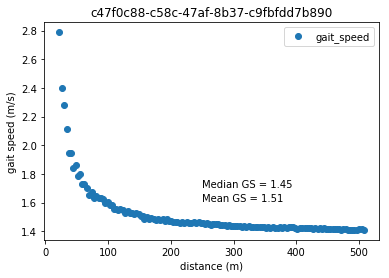

mean gait speed =  1.98
median gait speed =  1.97


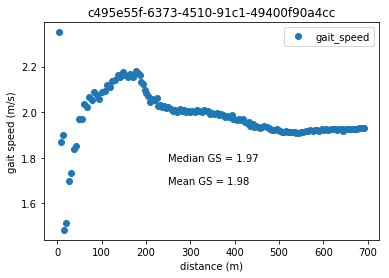

mean gait speed =  1.73
median gait speed =  1.72


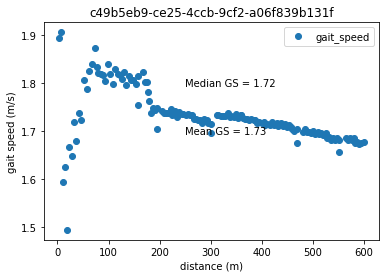

mean gait speed =  1.45
median gait speed =  1.51


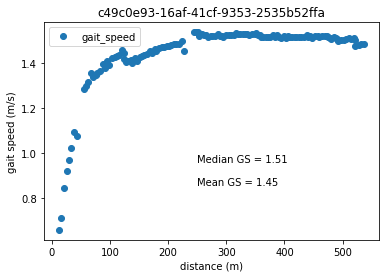

mean gait speed =  2.16
median gait speed =  2.29


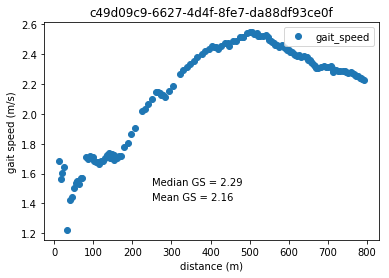

mean gait speed =  2.19
median gait speed =  2.31


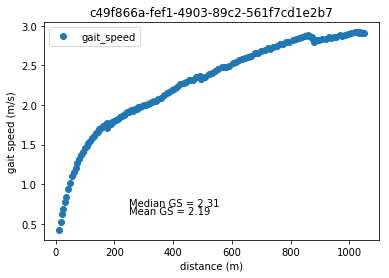

mean gait speed =  1.29
median gait speed =  1.3


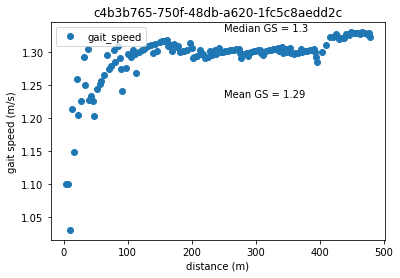

mean gait speed =  0.91
median gait speed =  0.85


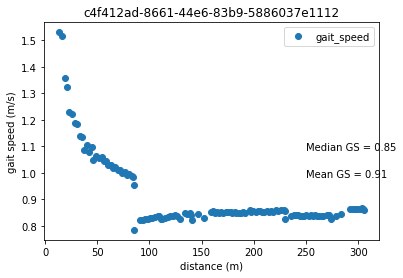

mean gait speed =  2.16
median gait speed =  2.27


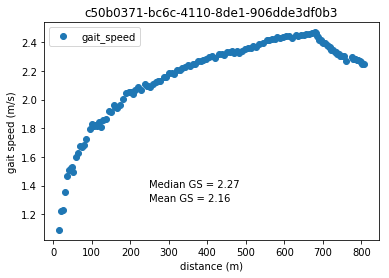

mean gait speed =  1.34
median gait speed =  1.33


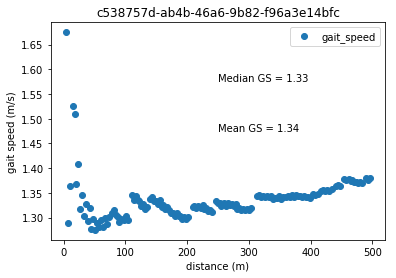

mean gait speed =  1.51
median gait speed =  1.48


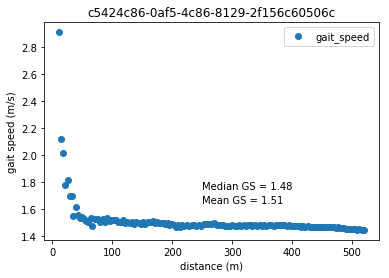

mean gait speed =  1.7
median gait speed =  1.7


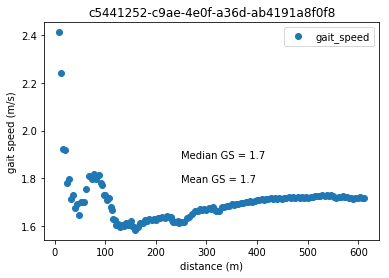

mean gait speed =  1.87
median gait speed =  1.85


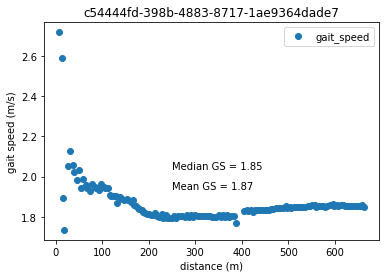

mean gait speed =  1.23
median gait speed =  1.17


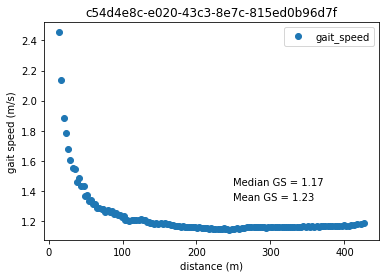

mean gait speed =  1.96
median gait speed =  1.96


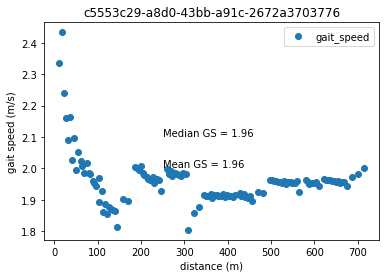

mean gait speed =  2.62
median gait speed =  2.63


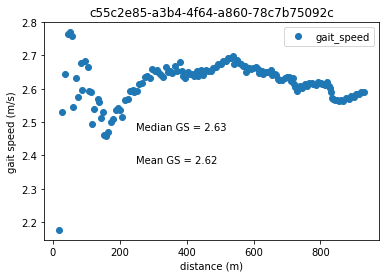

mean gait speed =  1.78
median gait speed =  1.77


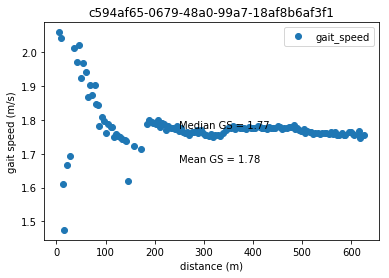

mean gait speed =  1.28
median gait speed =  1.27


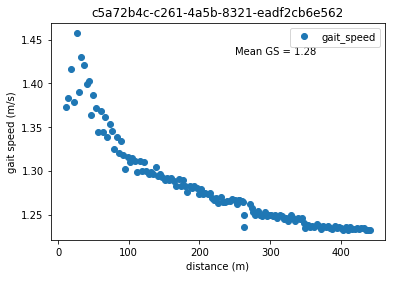

mean gait speed =  1.56
median gait speed =  1.54


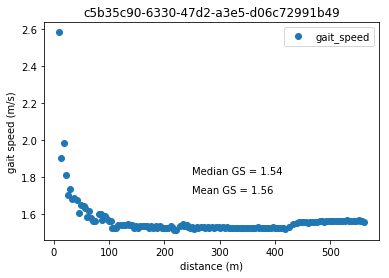

mean gait speed =  1.26
median gait speed =  1.29


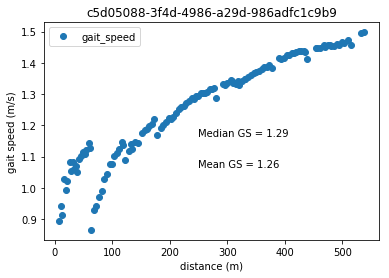

mean gait speed =  2.2
median gait speed =  2.23


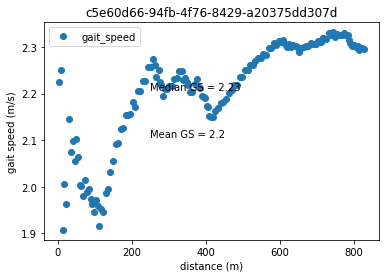

mean gait speed =  2.4
median gait speed =  2.36


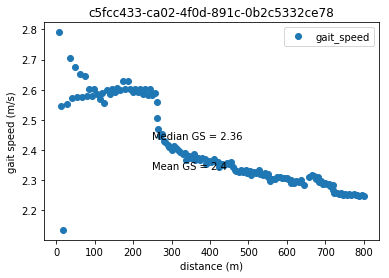

mean gait speed =  1.78
median gait speed =  1.67


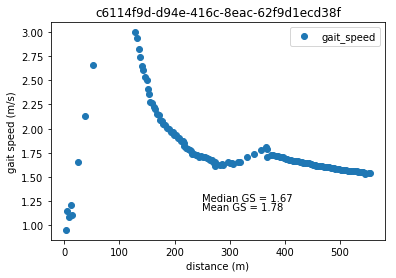

mean gait speed =  1.65
median gait speed =  1.67


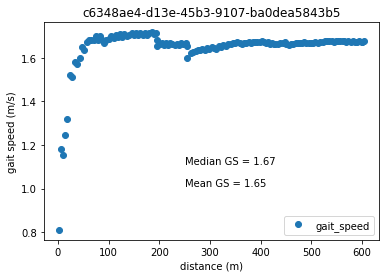

mean gait speed =  1.35
median gait speed =  1.39


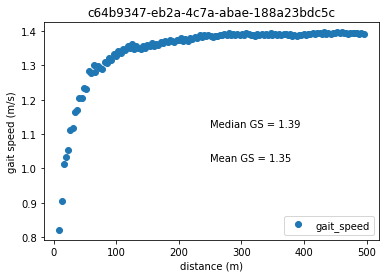

mean gait speed =  1.7
median gait speed =  1.69


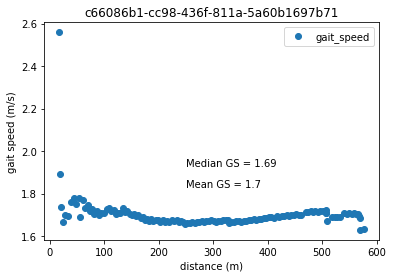

mean gait speed =  1.68
median gait speed =  1.68


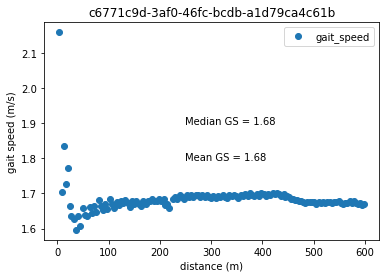

mean gait speed =  1.73
median gait speed =  1.76


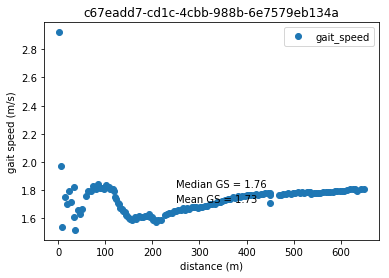

mean gait speed =  1.76
median gait speed =  1.78


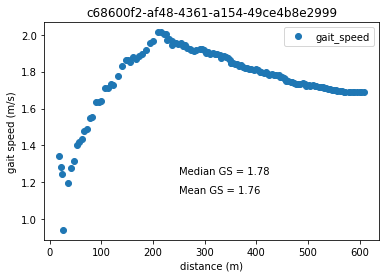

mean gait speed =  1.14
median gait speed =  1.1


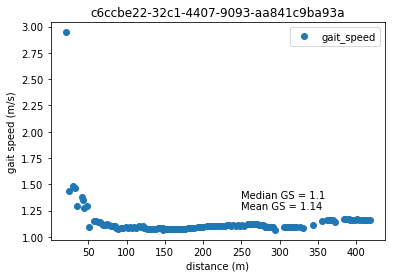

mean gait speed =  1.63
median gait speed =  1.59


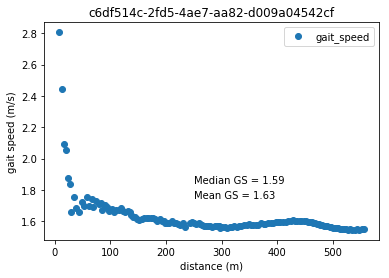

mean gait speed =  1.75
median gait speed =  1.72


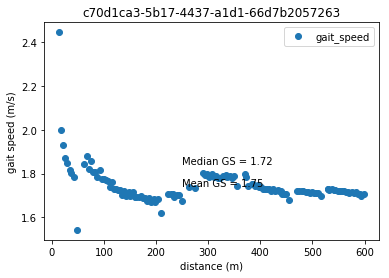

mean gait speed =  1.98
median gait speed =  2.01


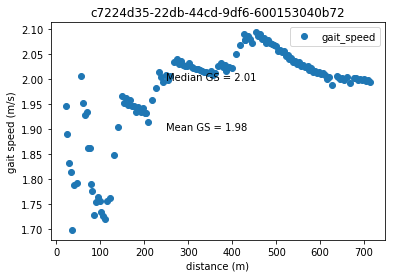

mean gait speed =  2.26
median gait speed =  2.24


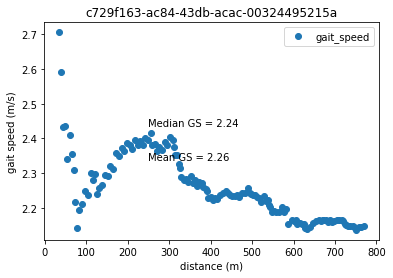

mean gait speed =  1.46
median gait speed =  1.46


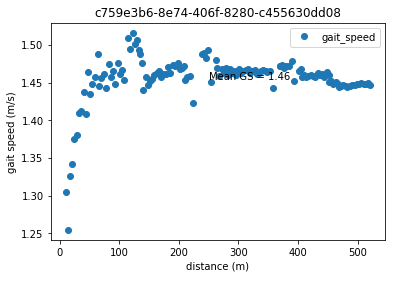

mean gait speed =  1.72
median gait speed =  1.72


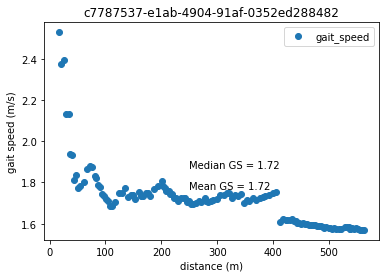

mean gait speed =  1.83
median gait speed =  1.86


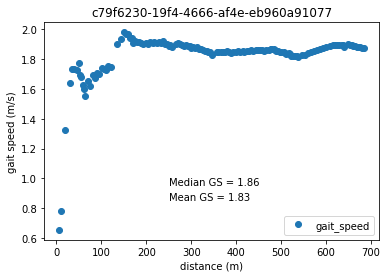

mean gait speed =  2.16
median gait speed =  2.19


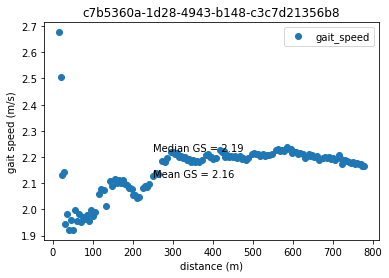

mean gait speed =  1.91
median gait speed =  1.84


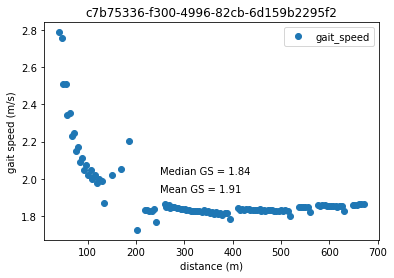

mean gait speed =  1.18
median gait speed =  1.16


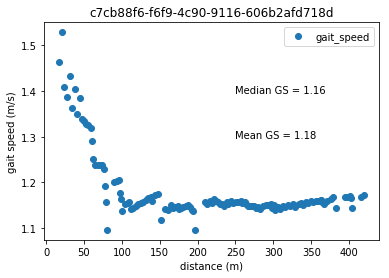

mean gait speed =  1.62
median gait speed =  1.6


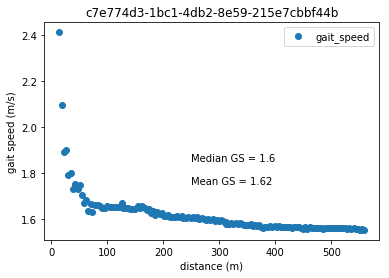

mean gait speed =  1.28
median gait speed =  1.27


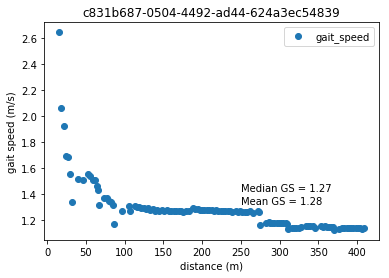

mean gait speed =  1.56
median gait speed =  1.55


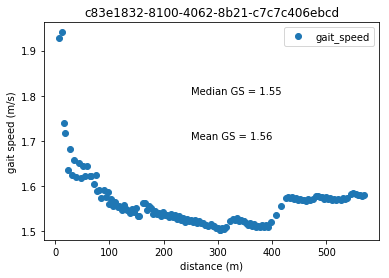

mean gait speed =  1.58
median gait speed =  1.66


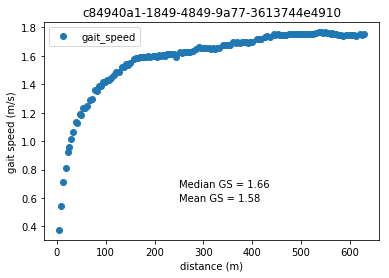

mean gait speed =  1.4
median gait speed =  1.44


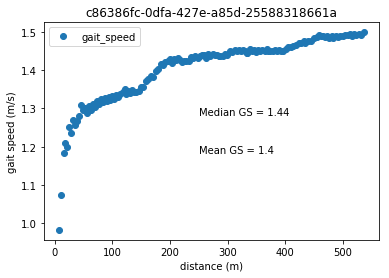

mean gait speed =  1.48
median gait speed =  1.52


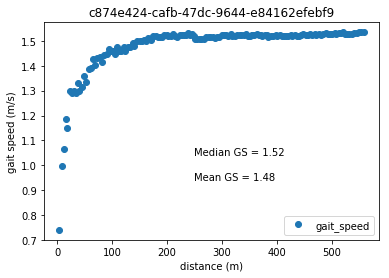

mean gait speed =  1.69
median gait speed =  1.68


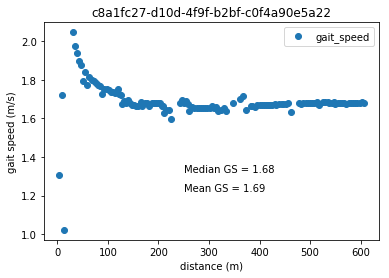

mean gait speed =  0.5
median gait speed =  0.51


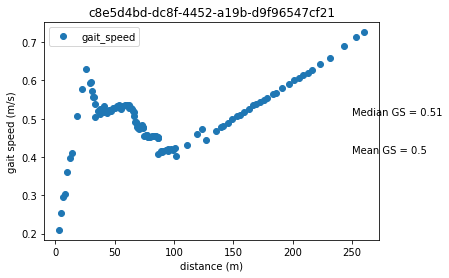

mean gait speed =  2.13
median gait speed =  2.2


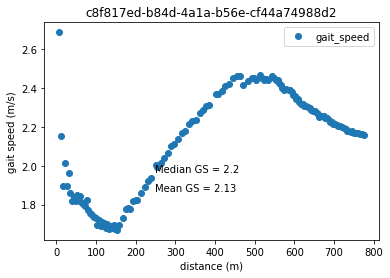

mean gait speed =  1.41
median gait speed =  1.45


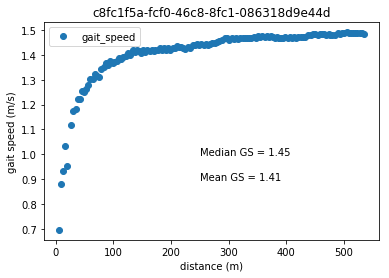

mean gait speed =  1.58
median gait speed =  1.56


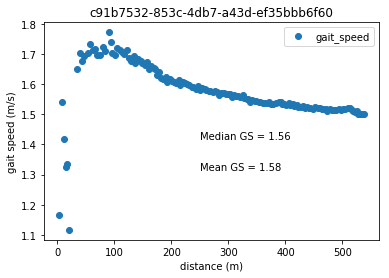

mean gait speed =  1.36
median gait speed =  1.37


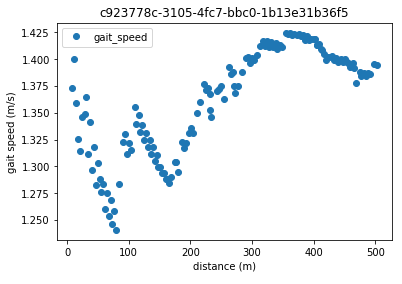

mean gait speed =  1.8
median gait speed =  1.87


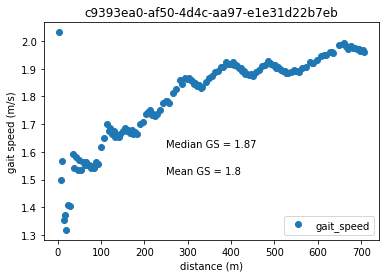

mean gait speed =  1.37
median gait speed =  1.37


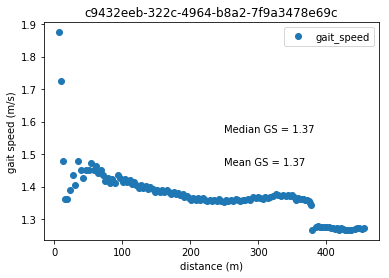

mean gait speed =  1.76
median gait speed =  1.75


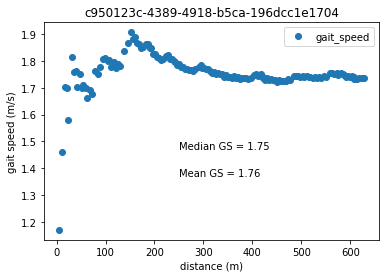

mean gait speed =  1.43
median gait speed =  1.43


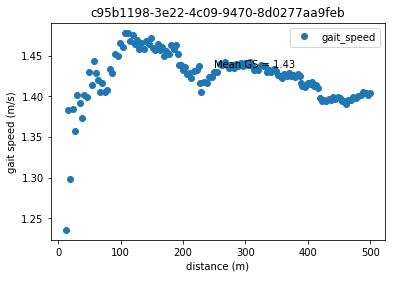

mean gait speed =  1.67
median gait speed =  1.7


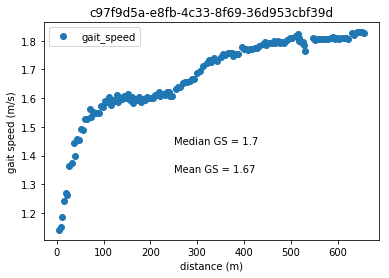

mean gait speed =  1.12
median gait speed =  1.09


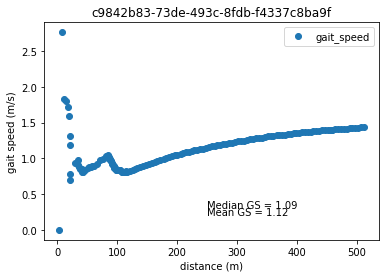

mean gait speed =  2.47
median gait speed =  2.54


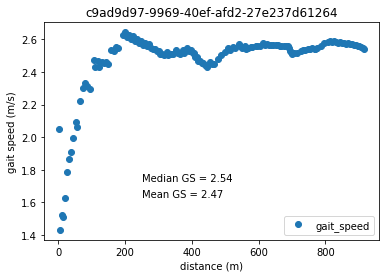

mean gait speed =  1.78
median gait speed =  1.72


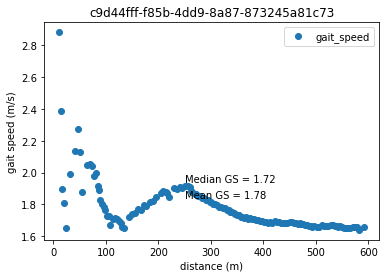

mean gait speed =  1.3
median gait speed =  1.31


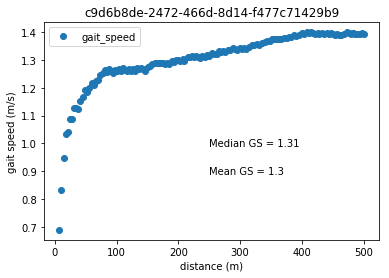

mean gait speed =  2.25
median gait speed =  2.21


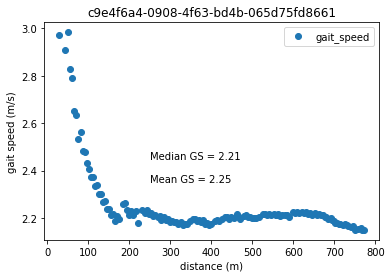

mean gait speed =  1.62
median gait speed =  1.57


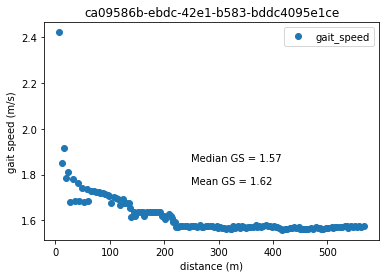

mean gait speed =  1.77
median gait speed =  1.78


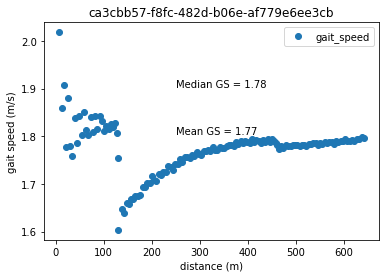

mean gait speed =  1.71
median gait speed =  1.73


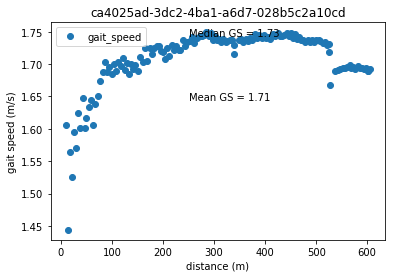

mean gait speed =  1.53
median gait speed =  1.57


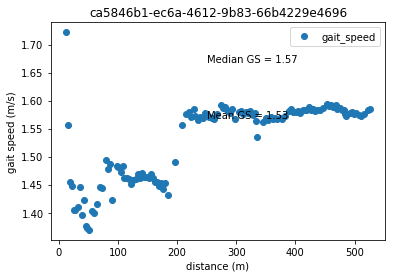

mean gait speed =  1.41
median gait speed =  1.4


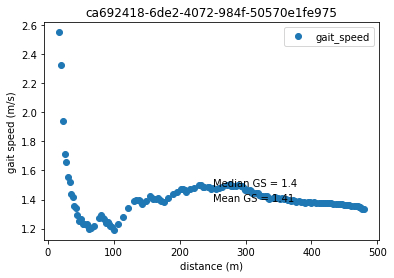

mean gait speed =  1.32
median gait speed =  1.32


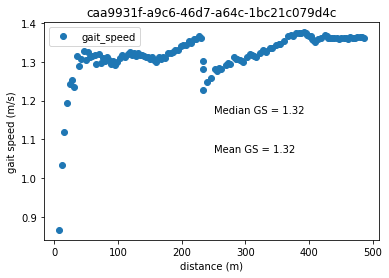

mean gait speed =  1.87
median gait speed =  1.86


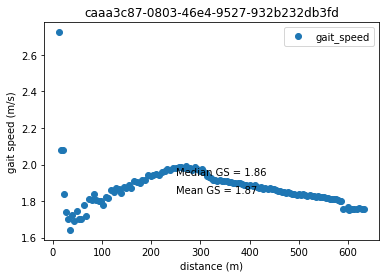

mean gait speed =  1.97
median gait speed =  1.93


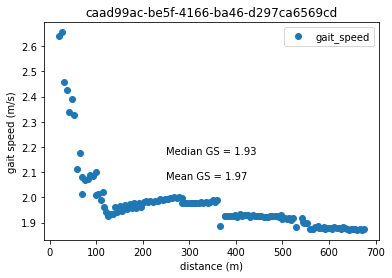

mean gait speed =  1.13
median gait speed =  1.06


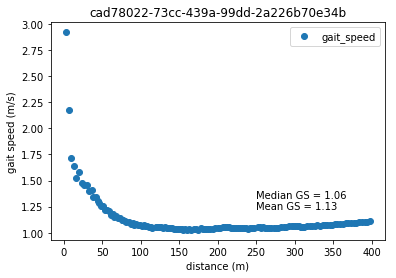

mean gait speed =  1.65
median gait speed =  1.67


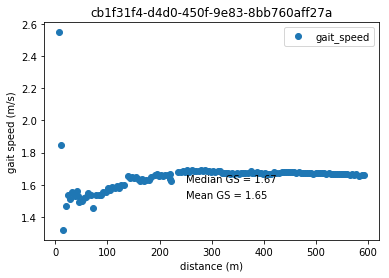

mean gait speed =  1.32
median gait speed =  1.34


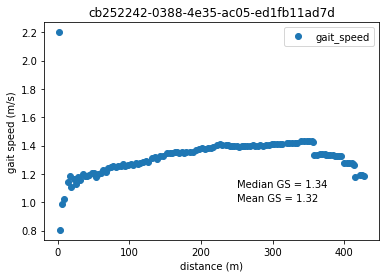

mean gait speed =  1.65
median gait speed =  1.69


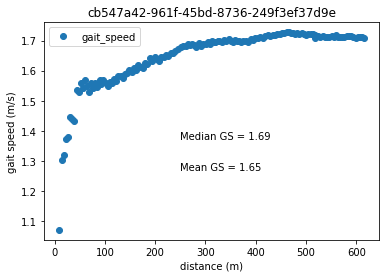

mean gait speed =  1.49
median gait speed =  1.49


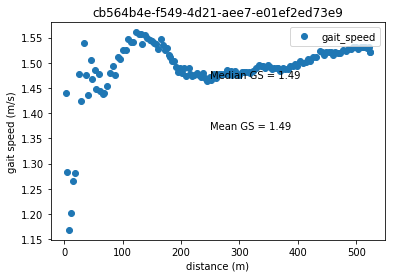

mean gait speed =  1.39
median gait speed =  1.38


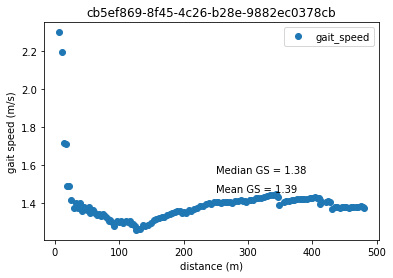

mean gait speed =  1.45
median gait speed =  1.41


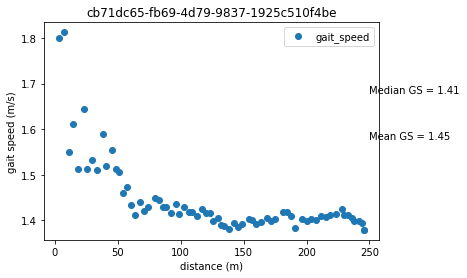

mean gait speed =  1.72
median gait speed =  1.64


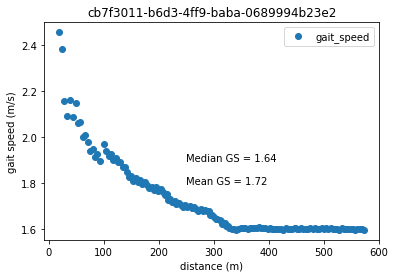

mean gait speed =  1.36
median gait speed =  1.47


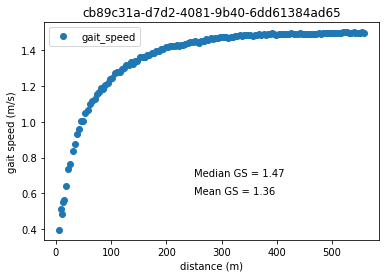

mean gait speed =  2.31
median gait speed =  2.3


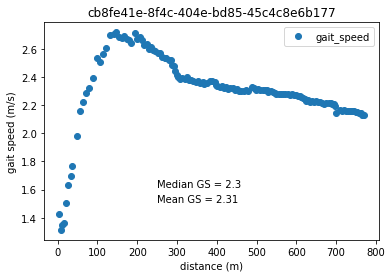

mean gait speed =  1.52
median gait speed =  1.52


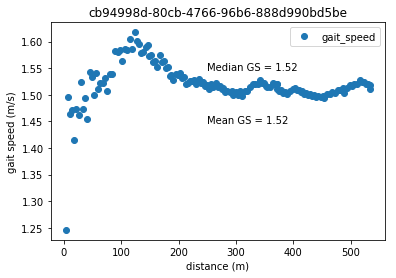

mean gait speed =  0.94
median gait speed =  0.99


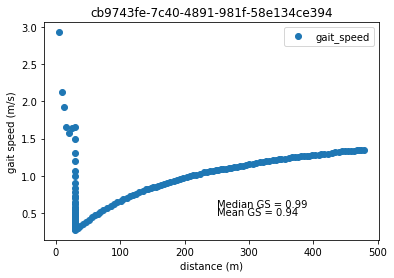

mean gait speed =  1.62
median gait speed =  1.6


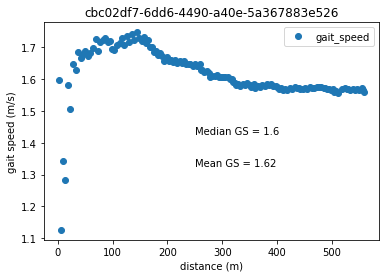

mean gait speed =  1.09
median gait speed =  1.1


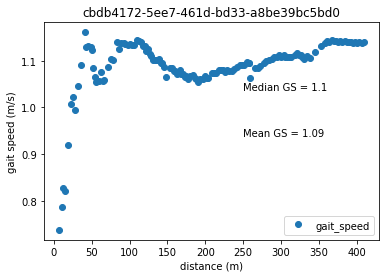

mean gait speed =  1.62
median gait speed =  1.63


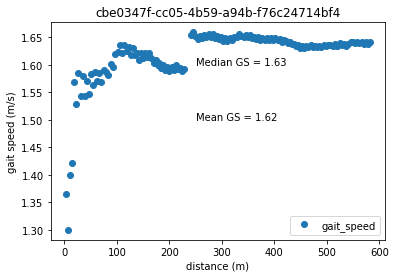

mean gait speed =  2.39
median gait speed =  2.48


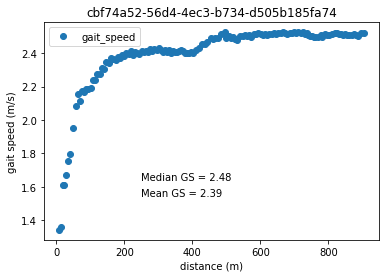

mean gait speed =  1.03
median gait speed =  0.99


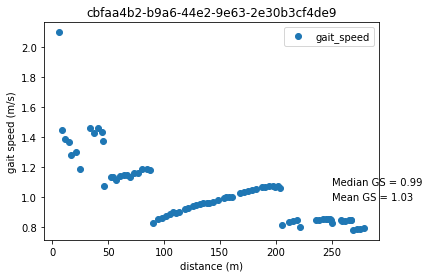

mean gait speed =  1.38
median gait speed =  1.41


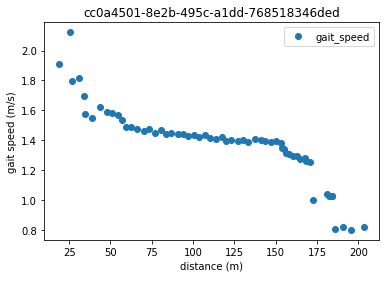

mean gait speed =  1.56
median gait speed =  1.53


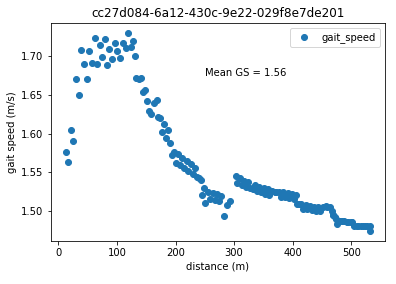

mean gait speed =  1.75
median gait speed =  1.76


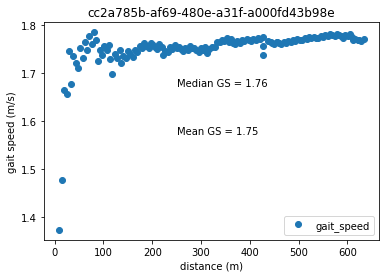

mean gait speed =  1.57
median gait speed =  1.6


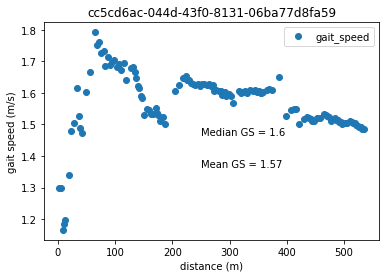

mean gait speed =  1.71
median gait speed =  1.67


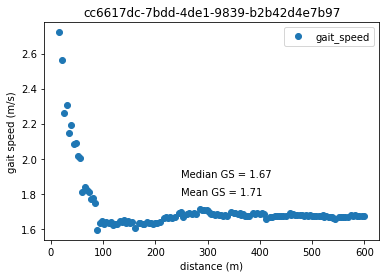

mean gait speed =  1.15
median gait speed =  1.13


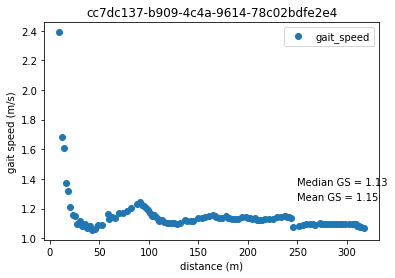

mean gait speed =  1.52
median gait speed =  1.53


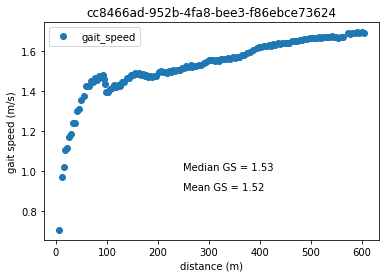

mean gait speed =  1.75
median gait speed =  1.72


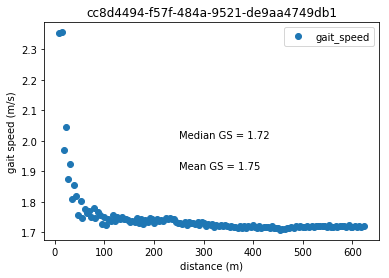

mean gait speed =  1.9
median gait speed =  1.91


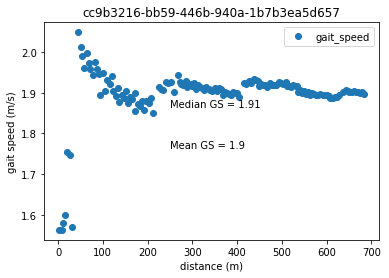

mean gait speed =  1.37
median gait speed =  1.37


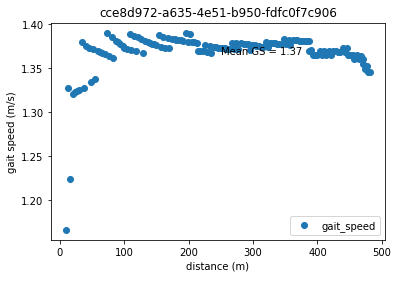

mean gait speed =  1.64
median gait speed =  1.64


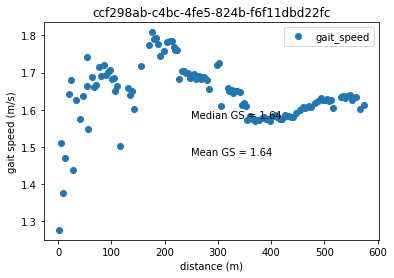

mean gait speed =  1.43
median gait speed =  1.41


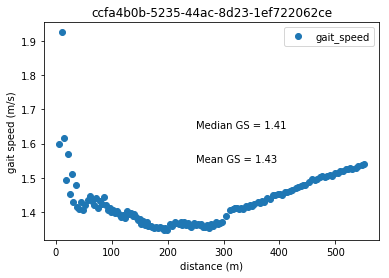

mean gait speed =  1.35
median gait speed =  1.35


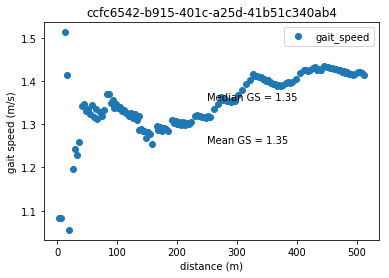

mean gait speed =  1.57
median gait speed =  1.52


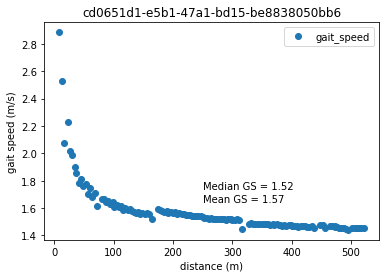

mean gait speed =  1.18
median gait speed =  1.17


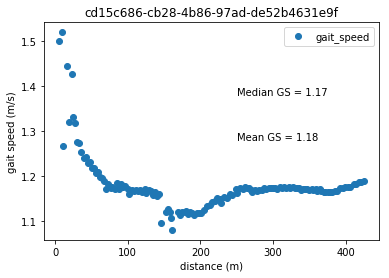

mean gait speed =  2.1
median gait speed =  2.04


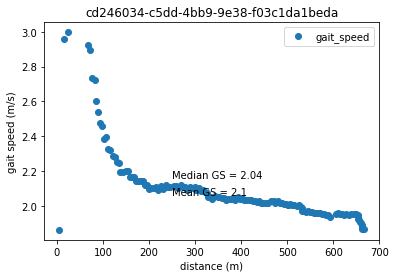

mean gait speed =  1.62
median gait speed =  1.59


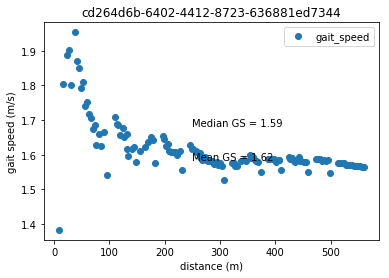

mean gait speed =  1.47
median gait speed =  1.48


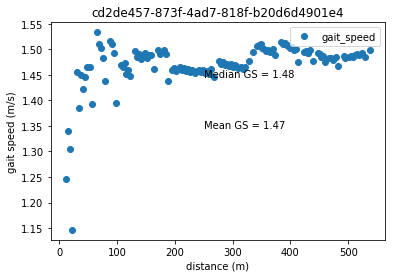

mean gait speed =  1.55
median gait speed =  1.55


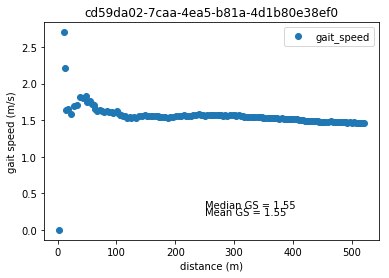

mean gait speed =  1.54
median gait speed =  1.54


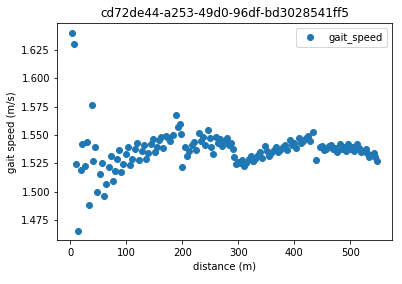

mean gait speed =  1.47
median gait speed =  1.5


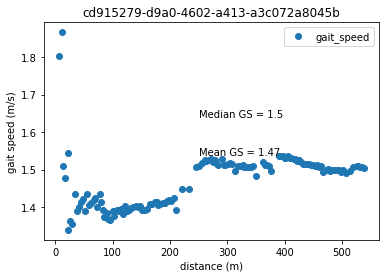

mean gait speed =  1.72
median gait speed =  1.73


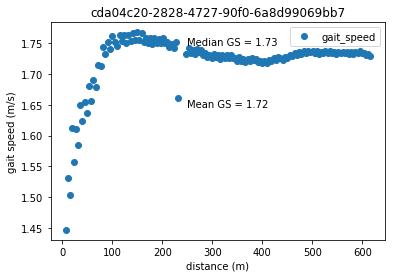

mean gait speed =  1.67
median gait speed =  1.69


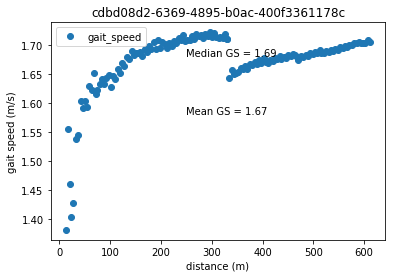

mean gait speed =  1.46
median gait speed =  1.49


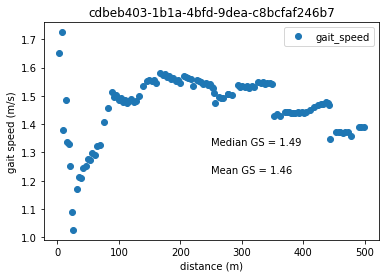

mean gait speed =  1.3
median gait speed =  1.39


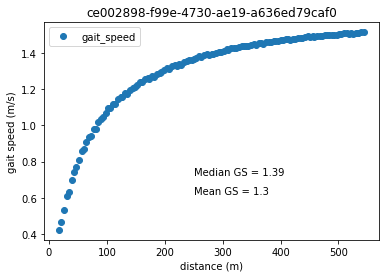

mean gait speed =  1.62
median gait speed =  1.61


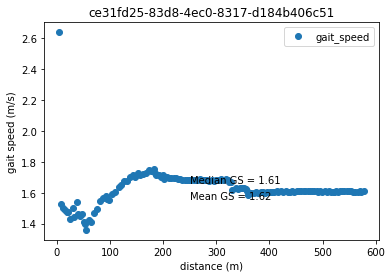

mean gait speed =  1.66
median gait speed =  1.77


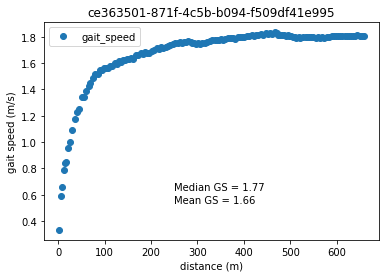

mean gait speed =  1.07
median gait speed =  1.04


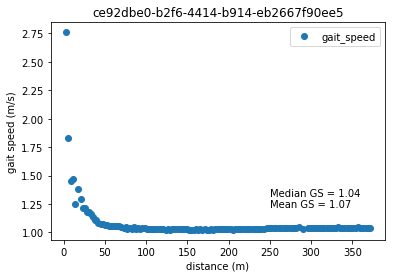

mean gait speed =  1.32
median gait speed =  1.26


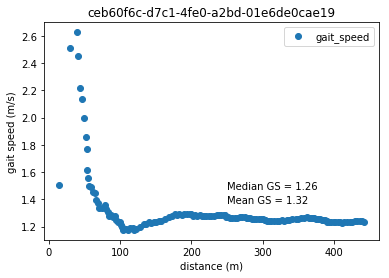

mean gait speed =  2.76
median gait speed =  2.85


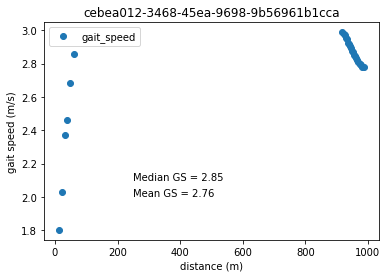

mean gait speed =  1.97
median gait speed =  1.99


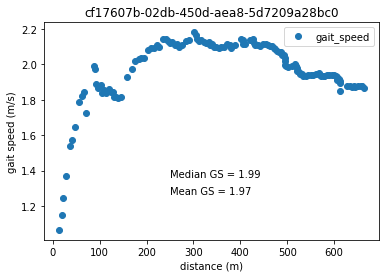

mean gait speed =  1.92
median gait speed =  2.06


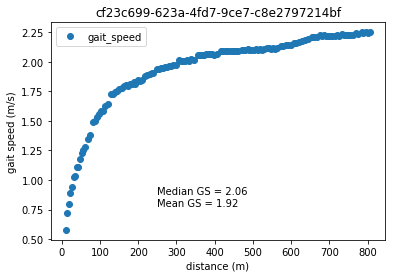

mean gait speed =  1.59
median gait speed =  1.63


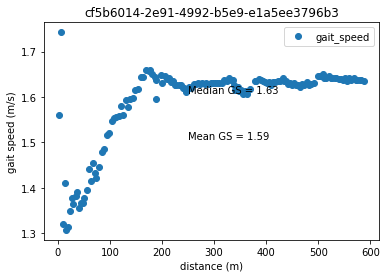

mean gait speed =  1.63
median gait speed =  1.64


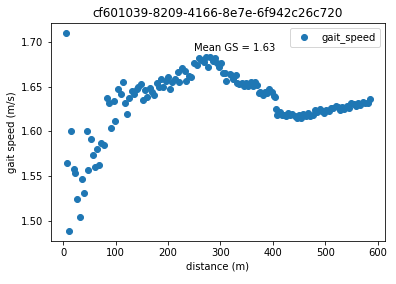

mean gait speed =  1.74
median gait speed =  1.74


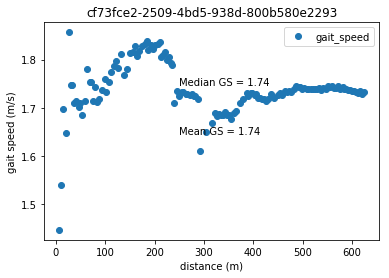

mean gait speed =  1.55
median gait speed =  1.53


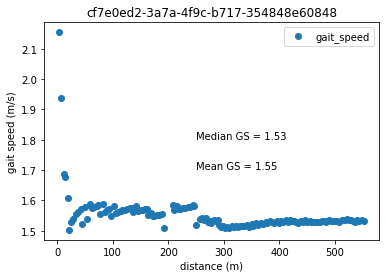

mean gait speed =  1.89
median gait speed =  1.88


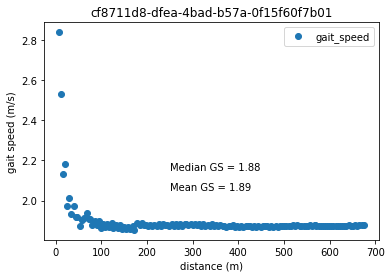

mean gait speed =  1.43
median gait speed =  1.42


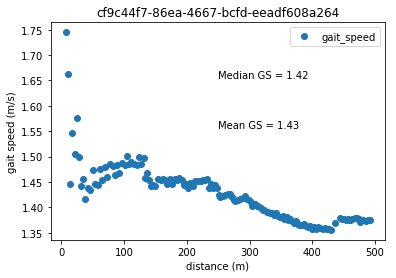

mean gait speed =  1.7
median gait speed =  1.67


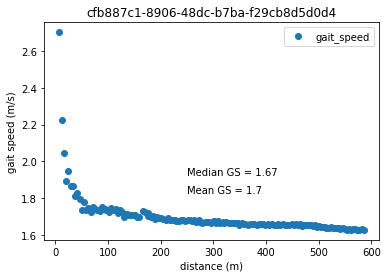

mean gait speed =  2.09
median gait speed =  2.04


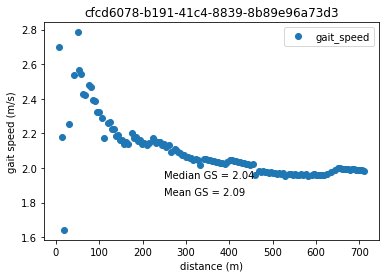

mean gait speed =  1.0
median gait speed =  0.99


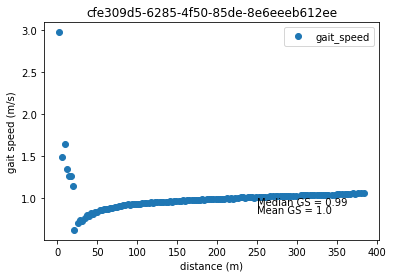

mean gait speed =  1.79
median gait speed =  1.8


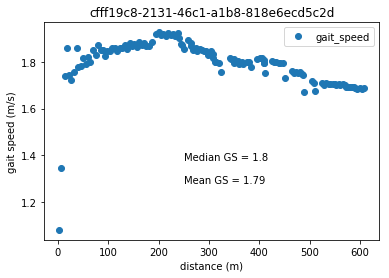

In [3]:
#call all functions, listed below

#walk_data is whatever your datapath is the pedometer files (as json files)
walk_data = glob2.glob('/Users/nicolemoyen/Dropbox/Stanford/AshleyLab/6mwt_subset/*/')

#import_files function takes a folder that has pedometer files from 6MWT in it
ped_df = import_files(walk_data)

gait_df, data_fix = gait_speed(ped_df)